In [1]:
# Setup
import pandas as pd
import numpy as np
import git
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, sampler
import torchvision.transforms as T

import matplotlib.pyplot as plt
%matplotlib inline

repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir
dtype=torch.float32

from barebone import *
from model_util import *

USE_GPU = True
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

/opt/conda/envs/posedemo/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load keypoints

In [2]:
subjects = np.load("{}/preprocessing/poseformer/subjects.npy".format(homedir))
keypoints3d = np.load("{}/preprocessing/poseformer/joints_3d_padded.npy".format(homedir))
print(keypoints3d.shape)

(384, 1511, 17, 3)


In [3]:
num_samples = keypoints3d.shape[0]
keypoints3d = keypoints3d.reshape((num_samples, -1))      # Flatten frame, joint and coordinates
df_kp3d = pd.DataFrame(keypoints3d)
df_kp3d.insert(0, 'subjectid', subjects)

df_kp3d

subjectid    0    1         2         3         4         5  \
0                  kEC7G8DP  0.0  0.0  0.553803  0.118477  0.048315  0.559740   
1                  GjPHiGli  0.0  0.0  0.743547  0.134699  0.026321  0.732065   
2                  RFibHPt7  0.0  0.0  0.603302  0.016389  0.139365  0.610147   
3                  gO7Cpt1X  0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
4                  xEIsrkiR  0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
..                      ...  ...  ...       ...       ...       ...       ...   
379  VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
380                8elUiJYv  0.0  0.0  0.630345  0.098289  0.083985  0.633622   
381  PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
382                q8FyLMSn  0.0  0.0  0.620147  0.140228  0.037624  0.613141   
383                pmYdj2Zc  0.0  0.0  0.845058  0.019990  0.057908  0.821042   

            6         7         8  ...  77051  77052  77053  77054  77055  \
0    0.078025  0.448527  0.405209  ...    0.0    0.0    0.0    0.0    0.0   
1   -0.058176  0.387448  0.505844  ...    0.0    0.0    0.0    0.0    0.0   
2   -0.268166  0.238692  0.415880  ...    0.0    0.0    0.0    0.0    0.0   
3    0.469379  0.117718  0.449701  ...    0.0    0.0    0.0    0.0    0.0   
4    0.010256  0.230066  0.288412  ...    0.0    0.0    0.0    0.0    0.0   
..        ...       ...       ...  ...    ...    ...    ...    ...    ...   
379  0.106557  0.084857  0.421844  ...    0.0    0.0    0.0    0.0    0.0   
380  0.120486  0.398054  0.393028  ...    0.0    0.0    0.0    0.0    0.0   
381  0.042036 -0.115334  0.418619  ...    0.0    0.0    0.0    0.0    0.0   
382  0.192907  0.430776  0.407713  ...    0.0    0.0    0.0    0.0    0.0   
383  0.170526 -0.006771  0.373800  ...    0.0    0.0    0.0    0.0    0.0   

     77056  77057  77058  77059  77060  
0      0.0    0.0    0.0    0.0    0.0  
1      0.0    0.0    0.0    0.0    0.0  
2      0.0    0.0    0.0    0.0    0.0  
3      0.0    0.0    0.0    0.0    0.0  
4      0.0    0.0    0.0    0.0    0.0  
..     ...    ...    ...    ...    ...  
379    0.0    0.0    0.0    0.0    0.0  
380    0.0    0.0    0.0    0.0    0.0  
381    0.0    0.0    0.0    0.0    0.0  
382    0.0    0.0    0.0    0.0    0.0  
383    0.0    0.0    0.0    0.0    0.0  

[384 rows x 77062 columns]

### Load Survey Data (labels)

In [4]:
df_survey = pd.read_csv(r'https://raw.githubusercontent.com/amandaliusa/cs231n/main/data/survey_data.csv')
df_survey

subjectid  OA_check
0    kGhQ1FQc         1
1    KyINSk8e         0
2    ybGzWMPA         0
3    b632WDpF         0
4    UDXlpEgF         0
..        ...       ...
400  tFSyXitq         1
401  OuYG4U64         0
402  nM7tQcBS         0
403  zN0O4jLu         0
404  ESzlIzyO         0

[405 rows x 2 columns]

### Preprocessing 

- Create train/val/test sets
- Normalization
- Oversampling
- Hand-pick features

In [5]:
# join the dataframes by subjectId 
df_join = df_kp3d.set_index('subjectid').join(df_survey.set_index('subjectid')).astype('float32')
df_join

0    1         2         3         4         5  \
subjectid                                                                  
kEC7G8DP                0.0  0.0  0.553803  0.118477  0.048315  0.559740   
GjPHiGli                0.0  0.0  0.743547  0.134699  0.026321  0.732065   
RFibHPt7                0.0  0.0  0.603302  0.016389  0.139365  0.610147   
gO7Cpt1X                0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
xEIsrkiR                0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
...                     ...  ...       ...       ...       ...       ...   
VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
8elUiJYv                0.0  0.0  0.630345  0.098289  0.083985  0.633622   
PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
q8FyLMSn                0.0  0.0  0.620147  0.140228  0.037624  0.613141   
pmYdj2Zc                0.0  0.0  0.845058  0.019990  0.057908  0.821042   

                               6         7         8         9  ...  77052  \
subjectid                                                       ...          
kEC7G8DP                0.078025  0.448527  0.405209  0.135244  ...    0.0   
GjPHiGli               -0.058176  0.387448  0.505844  0.043619  ...    0.0   
RFibHPt7               -0.268166  0.238692  0.415880 -0.284261  ...    0.0   
gO7Cpt1X                0.469379  0.117718  0.449701  0.328360  ...    0.0   
xEIsrkiR                0.010256  0.230066  0.288412  0.128244  ...    0.0   
...                          ...       ...       ...       ...  ...    ...   
VID_20230506_175810340  0.106557  0.084857  0.421844 -0.013960  ...    0.0   
8elUiJYv                0.120486  0.398054  0.393028  0.052458  ...    0.0   
PXL_20230505_234002299  0.042036 -0.115334  0.418619 -0.127163  ...    0.0   
q8FyLMSn                0.192907  0.430776  0.407713  0.130702  ...    0.0   
pmYdj2Zc                0.170526 -0.006771  0.373800  0.084793  ...    0.0   

                        77053  77054  77055  77056  77057  77058  77059  \
subjectid                                                                 
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                       ...    ...    ...    ...    ...    ...    ...   
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        77060  OA_check  
subjectid                                
kEC7G8DP                  0.0       0.0  
GjPHiGli                  0.0       0.0  
RFibHPt7                  0.0       0.0  
gO7Cpt1X                  0.0       0.0  
xEIsrkiR                  0.0       0.0  
...                       ...       ...  
VID_20230506_175810340    0.0       NaN  
8elUiJYv                  0.0       0.0  
PXL_20230505_234002299    0.0       NaN  
q8FyLMSn                  0.0       0.0  
pmYdj2Zc                  0.0       0.0  

[384 rows x 77062 columns]

In [6]:
# all videos from the new clinical trial have OA=1 
df_join = df_join.fillna(value={'OA_check': 1})
df_join

0    1         2         3         4         5  \
subjectid                                                                  
kEC7G8DP                0.0  0.0  0.553803  0.118477  0.048315  0.559740   
GjPHiGli                0.0  0.0  0.743547  0.134699  0.026321  0.732065   
RFibHPt7                0.0  0.0  0.603302  0.016389  0.139365  0.610147   
gO7Cpt1X                0.0  0.0  0.567537  0.071610 -0.120018  0.568075   
xEIsrkiR                0.0  0.0  0.576566  0.126515 -0.013554  0.562857   
...                     ...  ...       ...       ...       ...       ...   
VID_20230506_175810340  0.0  0.0  1.006987  0.139903 -0.019908  0.980886   
8elUiJYv                0.0  0.0  0.630345  0.098289  0.083985  0.633622   
PXL_20230505_234002299  0.0  0.0  0.920654  0.071631 -0.096997  0.898501   
q8FyLMSn                0.0  0.0  0.620147  0.140228  0.037624  0.613141   
pmYdj2Zc                0.0  0.0  0.845058  0.019990  0.057908  0.821042   

                               6         7         8         9  ...  77052  \
subjectid                                                       ...          
kEC7G8DP                0.078025  0.448527  0.405209  0.135244  ...    0.0   
GjPHiGli               -0.058176  0.387448  0.505844  0.043619  ...    0.0   
RFibHPt7               -0.268166  0.238692  0.415880 -0.284261  ...    0.0   
gO7Cpt1X                0.469379  0.117718  0.449701  0.328360  ...    0.0   
xEIsrkiR                0.010256  0.230066  0.288412  0.128244  ...    0.0   
...                          ...       ...       ...       ...  ...    ...   
VID_20230506_175810340  0.106557  0.084857  0.421844 -0.013960  ...    0.0   
8elUiJYv                0.120486  0.398054  0.393028  0.052458  ...    0.0   
PXL_20230505_234002299  0.042036 -0.115334  0.418619 -0.127163  ...    0.0   
q8FyLMSn                0.192907  0.430776  0.407713  0.130702  ...    0.0   
pmYdj2Zc                0.170526 -0.006771  0.373800  0.084793  ...    0.0   

                        77053  77054  77055  77056  77057  77058  77059  \
subjectid                                                                 
kEC7G8DP                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
GjPHiGli                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
RFibHPt7                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
gO7Cpt1X                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
xEIsrkiR                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
...                       ...    ...    ...    ...    ...    ...    ...   
VID_20230506_175810340    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
8elUiJYv                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
PXL_20230505_234002299    0.0    0.0    0.0    0.0    0.0    0.0    0.0   
q8FyLMSn                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   
pmYdj2Zc                  0.0    0.0    0.0    0.0    0.0    0.0    0.0   

                        77060  OA_check  
subjectid                                
kEC7G8DP                  0.0       0.0  
GjPHiGli                  0.0       0.0  
RFibHPt7                  0.0       0.0  
gO7Cpt1X                  0.0       0.0  
xEIsrkiR                  0.0       0.0  
...                       ...       ...  
VID_20230506_175810340    0.0       1.0  
8elUiJYv                  0.0       0.0  
PXL_20230505_234002299    0.0       1.0  
q8FyLMSn                  0.0       0.0  
pmYdj2Zc                  0.0       0.0  

[384 rows x 77062 columns]

#### Data validation 

In [7]:
# do a stratified split so that each dataset has the same proportion of OA=0 and OA=1
y = df_join['OA_check']

# set a random seed for reproducibility 
np.random.seed(42)

# split out test set from train/val
train_val_indices, test_indices = train_test_split(np.arange(len(df_join)), test_size=0.1, stratify=y)

# split out val set from train
train_ind, val_ind = train_test_split(np.arange(len(train_val_indices)), test_size=0.11111, stratify=y[train_val_indices])
train_indices = train_val_indices[train_ind]
val_indices = train_val_indices[val_ind]

In [8]:
# 384 examples 
NUM_TRAIN = len(train_indices)
NUM_VAL = len(val_indices)

train_data = df_join.iloc[train_indices]
val_data = df_join.iloc[val_indices]
test_data = df_join.iloc[test_indices]

In [9]:
# Check for number of OA positive and number of samples in the dataset
# Total - 78% OA=0, 22% OA=1
print(df_join.iloc[:,-1].count())  # 384
print(df_join.iloc[:,-1].sum())    # 84
class_counts = [df_join.iloc[:,-1].count() - df_join.iloc[:,-1].sum(), df_join.iloc[:,-1].sum()]

# Train set - This implies that if the model always predicts 0, it would have 78% training accuracy
print(train_data.iloc[:,-1].count())  # 306
print(train_data.iloc[:,-1].sum())    # 67

# Validation set - This implies that if the model always predicts 0, it would have 79% val accuracy
print(val_data.iloc[:,-1].count())  # 39
print(val_data.iloc[:,-1].sum())    # 8

# Test set - This implies that if the model always predicts 0, it would have 77% test accuracy
print(test_data.iloc[:,-1].count())  # 39
print(test_data.iloc[:,-1].sum())    # 9

384
83.0
306
67.0
39
8.0
39
8.0


#### Normalization

In [10]:
# compute mean and std of the features 
means = []
stds = []
for column in train_data.iloc[:,:-1]: # only use training set, and exclude last column, which has labels
    column_np = train_data[column].to_numpy()
    means.append(np.mean(column_np))
    stds.append(np.std(column_np))
    
# apply normalization
def transform(feature): 
    return (feature - means) / stds

#### Create dataloaders

In [11]:
# with normalization, no oversampling
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

In [12]:
for i, (data, labels) in enumerate(loader_train):
  print(data.shape, labels.shape)
  print(data,labels)
  break

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


torch.Size([64, 77061]) torch.Size([64])
tensor([[    nan,     nan, -0.3703,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -1.4499,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -3.4933,  ..., 17.4642, 17.4642, 17.4642],
        ...,
        [    nan,     nan, -0.1688,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -0.4248,  ..., -0.0573, -0.0573, -0.0573],
        [    nan,     nan, -0.6553,  ..., -0.0573, -0.0573, -0.0573]]) tensor([0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0.,
        0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1.,
        0., 1., 0., 1., 0., 0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])


#### Create dataloaders with upsampling 

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


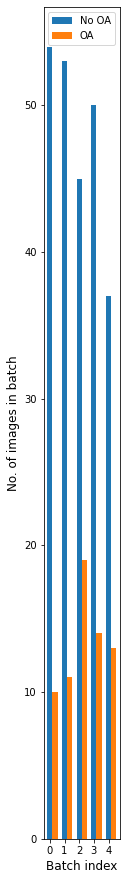

TypeError: cannot unpack non-iterable NoneType object

In [13]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# visualize training data imbalance
_, _, _ = visualise_dataloader(loader_train, {0: "No OA", 1: "OA"})

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


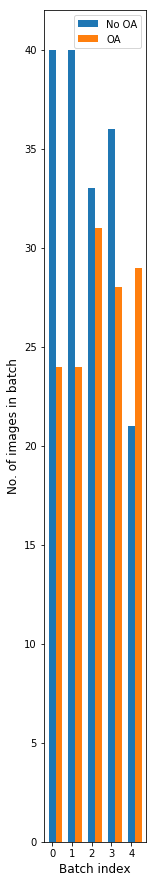

Avg Proportion of No OA per batch: 3.4
Avg Proportion of OA per batch: 2.7199999999999998
Num. unique images seen: 306/306


In [14]:
train = CustomDataset(dataframe=train_data, transform=transform)
class_weights = 1./torch.tensor(class_counts, dtype=torch.float) 
labels = train_data.iloc[:,-1]
class_weights_all = class_weights[labels]

# oversample the training data 
weighted_sampler = sampler.WeightedRandomSampler(
    weights=class_weights_all,
    num_samples=len(class_weights_all),
    replacement=True
)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

_, _, _ = visualise_dataloader(loader_train_os, {0: "No OA", 1: "OA"})

### BareBones Model

#### Train model with normalized inputs, no oversampling

In [15]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=20)

/opt/conda/envs/posedemo/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


Epoch 0, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 1, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 2, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 3, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 4, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 5, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 6, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 7, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 8, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 9, loss = nan, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000


KeyboardInterrupt: 

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs on oversampled training set

In [ ]:
train = CustomDataset(dataframe=train_data, transform=transform)
loader_train_os = DataLoader(train, batch_size=64, sampler=weighted_sampler)

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os, loader_val, epochs=50)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with normalized inputs, alternative oversampling 

In [ ]:
# oversample the train/val data by increasing number of OA=1 and increasing overall dataset size
#train_val_data = pd.concat([train_data, val_data], axis=0)
index_0 = train_data.index[train_data['OA_check'] == 0.0].tolist()
class_0 = train_data.loc[index_0]
index_1 = train_data.index[train_data['OA_check'] == 1.0].tolist()
class_1 = train_data.loc[index_1]
class_count_0 = len(class_0)
class_1_over = class_1.sample(class_count_0, replace=True)
train_over = pd.concat([class_1_over, class_0], axis=0)
# shuffle the DataFrame rows
train_over = train_over.sample(frac = 1)

NUM_TRAIN_OS = len(train_over)

train = CustomDataset(dataframe=train_over, transform=transform)
loader_train_os2 = DataLoader(train, batch_size=64, sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN_OS)))

val = CustomDataset(dataframe=val_data, transform=transform)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=transform)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train_os2, loader_val, epochs=50)

In [ ]:
fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling

In [ ]:
train = CustomDataset(dataframe=train_data)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data)
loader_test = DataLoader(test, batch_size=64)

In [ ]:
input_size = 77061
hidden_size = 500
num_classes = 1
model = Barebones_model(input_size, hidden_size, num_classes)
optimizer = optim.Adam(model.parameters(), lr=0.0001)
loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=50)

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(5, 1, figsize=(15, 15))

axes[0].set_title('Training loss')
axes[0].set_xlabel('Iteration')
axes[1].set_title('Training accuracy')
axes[1].set_xlabel('Epoch')
axes[2].set_title('Validation accuracy')
axes[2].set_xlabel('Epoch')
axes[3].set_title('Training Percent Positive Prediction')
axes[3].set_xlabel('Epoch')
axes[4].set_title('Validation Percent Positive Prediction')
axes[4].set_xlabel('Epoch')

axes[0].plot(loss, label="loss")
axes[1].plot(train_acc, label="training accuracy")
axes[2].plot(val_acc, label="validation accuracy")
axes[3].plot(train_pos, label="training % with positive predictions")
axes[4].plot(val_pos, label="validation % with positive predictions")
    
for ax in axes:
    ax.legend(loc='best', ncol=4)
    ax.grid(linestyle='--', linewidth=0.5)

plt.show()

#### Train model with unnormalized inputs, no oversampling, weighted loss

Epoch 0, loss = 1.0140, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 1.1278, train_acc = 79.4118, val_acc = 79.4872, train_pos = 2.6144, val_pos = 0.0000
Epoch 10, Average Validation F1 Score: 0.0
Epoch 20, loss = 1.2270, train_acc = 80.0654, val_acc = 87.1795, train_pos = 9.1503, val_pos = 7.6923
Epoch 20, Average Validation F1 Score: 0.5454545454545454
Epoch 30, loss = 1.0224, train_acc = 79.4118, val_acc = 84.6154, train_pos = 12.4183, val_pos = 10.2564
Epoch 30, Average Validation F1 Score: 0.5
Epoch 40, loss = 0.8955, train_acc = 79.0850, val_acc = 82.0513, train_pos = 14.7059, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.4615384615384615


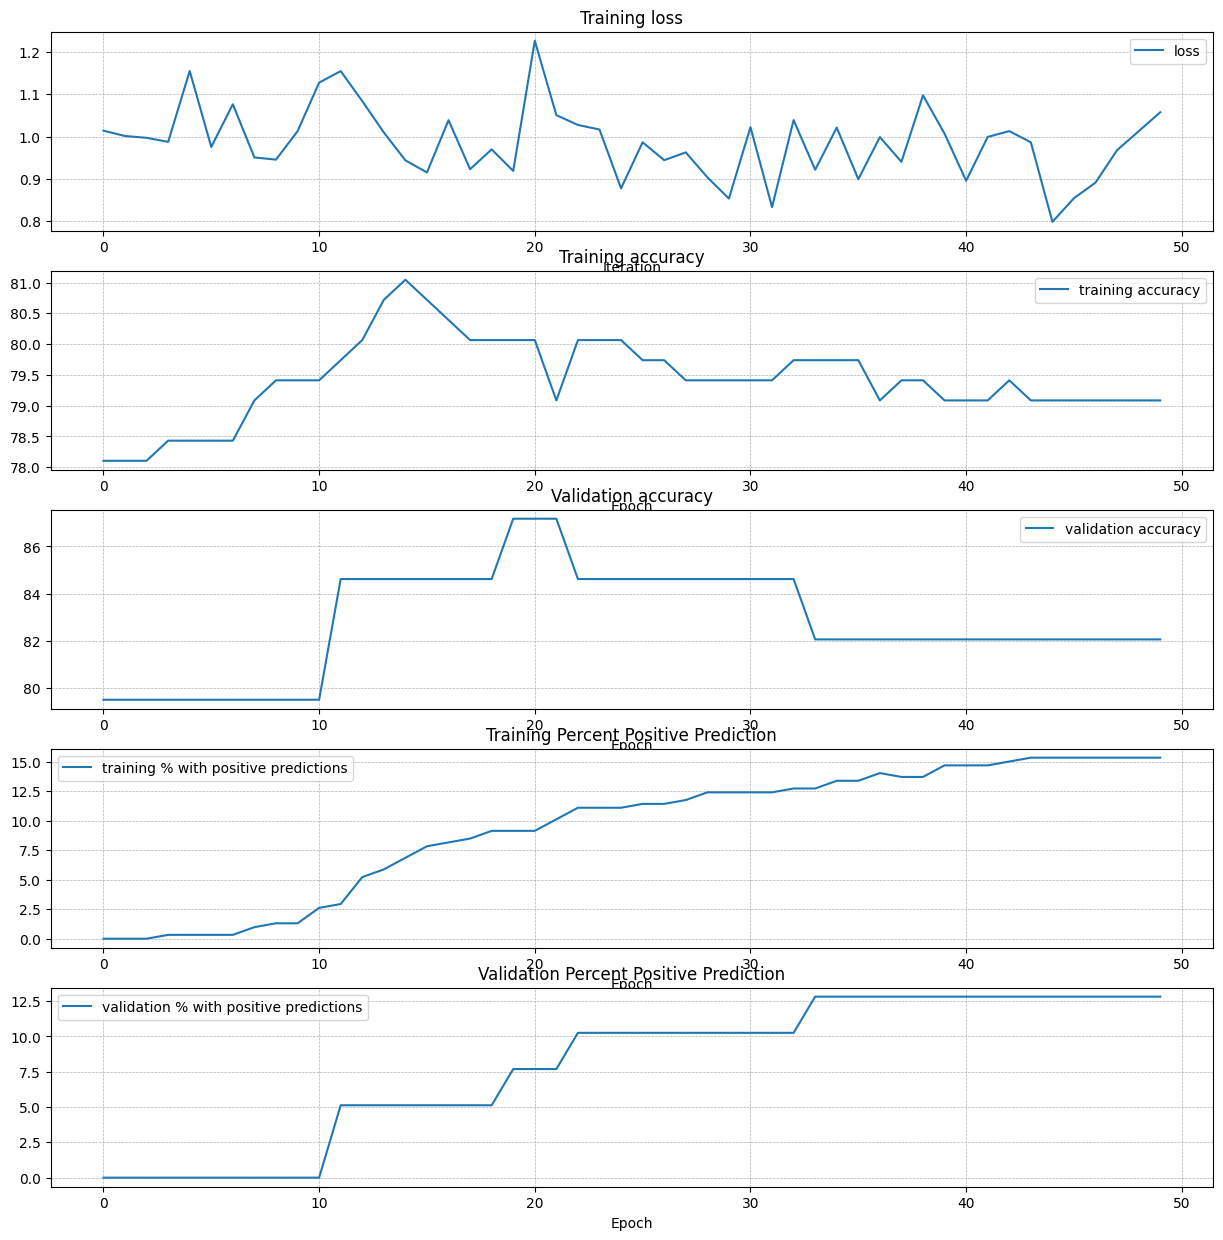

Finished running for lr: 1e-06, hidden size: 100, epochs: 50
Epoch 0, loss = 1.0760, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 1.1448, train_acc = 80.7190, val_acc = 79.4872, train_pos = 3.9216, val_pos = 0.0000
Epoch 10, Average Validation F1 Score: 0.0
Epoch 20, loss = 0.9805, train_acc = 79.7386, val_acc = 84.6154, train_pos = 11.4379, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 1.0378, train_acc = 79.4118, val_acc = 82.0513, train_pos = 14.3791, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.4615384615384615
Epoch 40, loss = 0.9312, train_acc = 79.0850, val_acc = 82.0513, train_pos = 15.3595, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.4615384615384615
Epoch 50, loss = 1.1104, train_acc = 78.7582, val_acc = 82.0513, train_pos = 15.6863, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.4615384615384615
Epoch 60, loss = 0

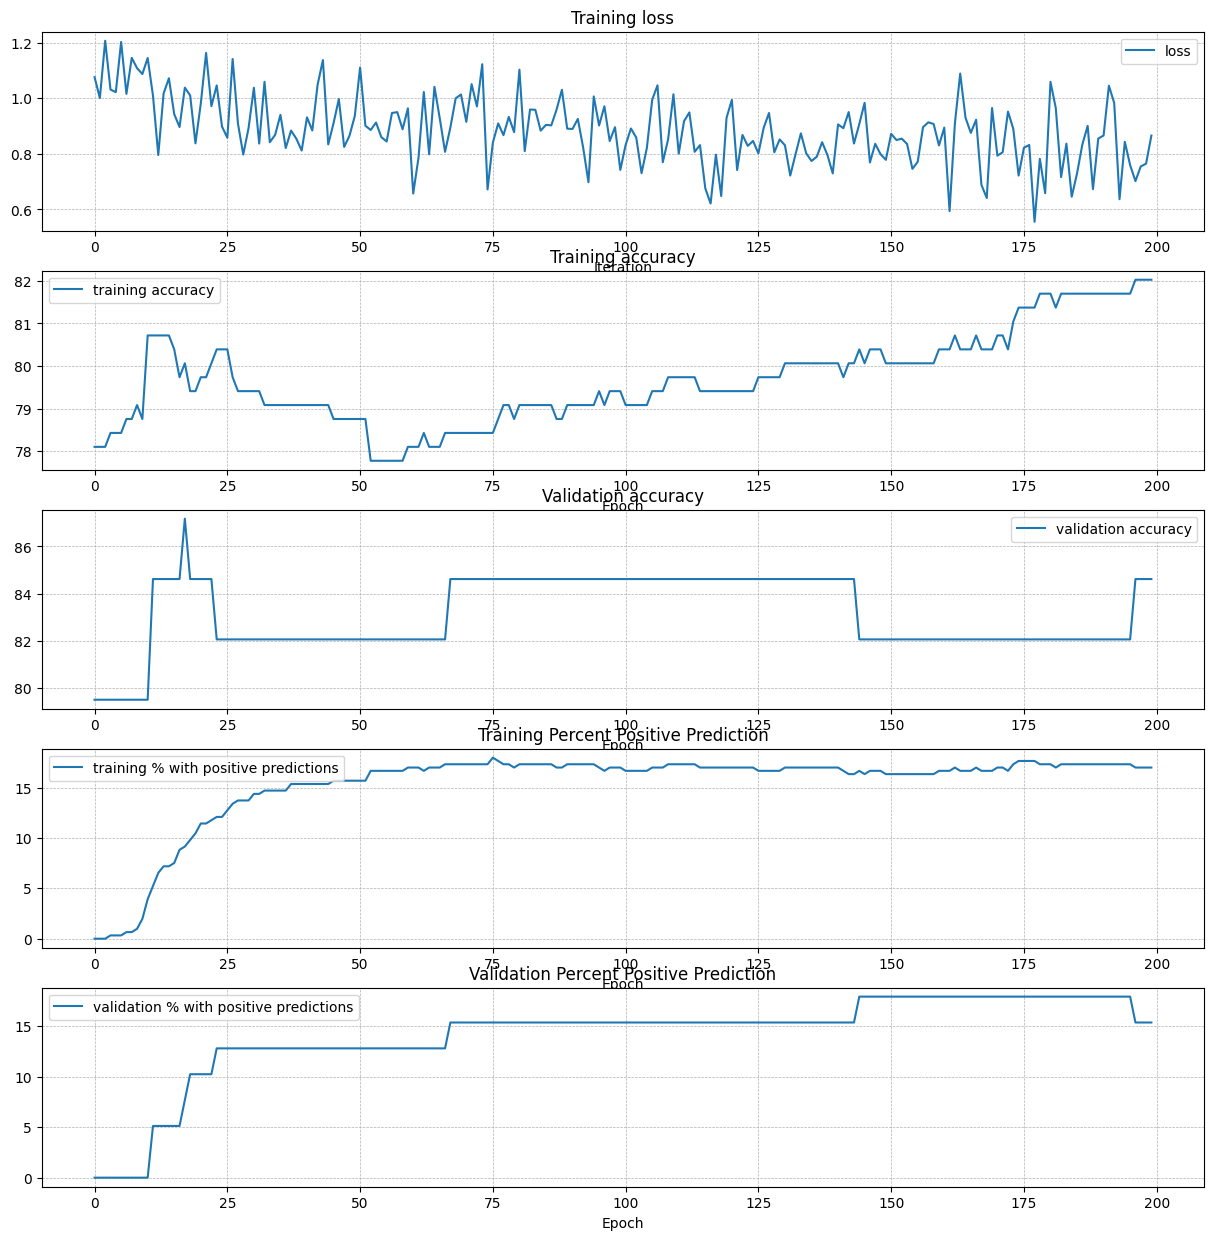

Finished running for lr: 1e-06, hidden size: 100, epochs: 200
Epoch 0, loss = 1.0113, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.8961, train_acc = 80.0654, val_acc = 84.6154, train_pos = 4.5752, val_pos = 5.1282
Epoch 10, Average Validation F1 Score: 0.4
Epoch 20, loss = 1.0161, train_acc = 79.7386, val_acc = 84.6154, train_pos = 10.7843, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.8987, train_acc = 78.7582, val_acc = 82.0513, train_pos = 15.0327, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.4615384615384615
Epoch 40, loss = 1.0355, train_acc = 78.7582, val_acc = 82.0513, train_pos = 15.6863, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.4615384615384615
Epoch 50, loss = 1.1569, train_acc = 78.1046, val_acc = 82.0513, train_pos = 16.3399, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.4615384615384615
Epoch 60, loss = 

Epoch 510, loss = 0.7072, train_acc = 85.9477, val_acc = 87.1795, train_pos = 18.3007, val_pos = 12.8205
Epoch 510, Average Validation F1 Score: 0.6153846153846154
Epoch 520, loss = 0.6126, train_acc = 86.2745, val_acc = 87.1795, train_pos = 17.9739, val_pos = 12.8205
Epoch 520, Average Validation F1 Score: 0.6153846153846154
Epoch 530, loss = 0.7515, train_acc = 85.9477, val_acc = 87.1795, train_pos = 18.3007, val_pos = 12.8205
Epoch 530, Average Validation F1 Score: 0.6153846153846154
Epoch 540, loss = 0.5824, train_acc = 85.9477, val_acc = 87.1795, train_pos = 18.3007, val_pos = 12.8205
Epoch 540, Average Validation F1 Score: 0.6153846153846154
Epoch 550, loss = 0.8586, train_acc = 86.6013, val_acc = 87.1795, train_pos = 17.6471, val_pos = 12.8205
Epoch 550, Average Validation F1 Score: 0.6153846153846154
Epoch 560, loss = 0.6561, train_acc = 86.6013, val_acc = 87.1795, train_pos = 17.6471, val_pos = 12.8205
Epoch 560, Average Validation F1 Score: 0.6153846153846154
Epoch 570, loss 

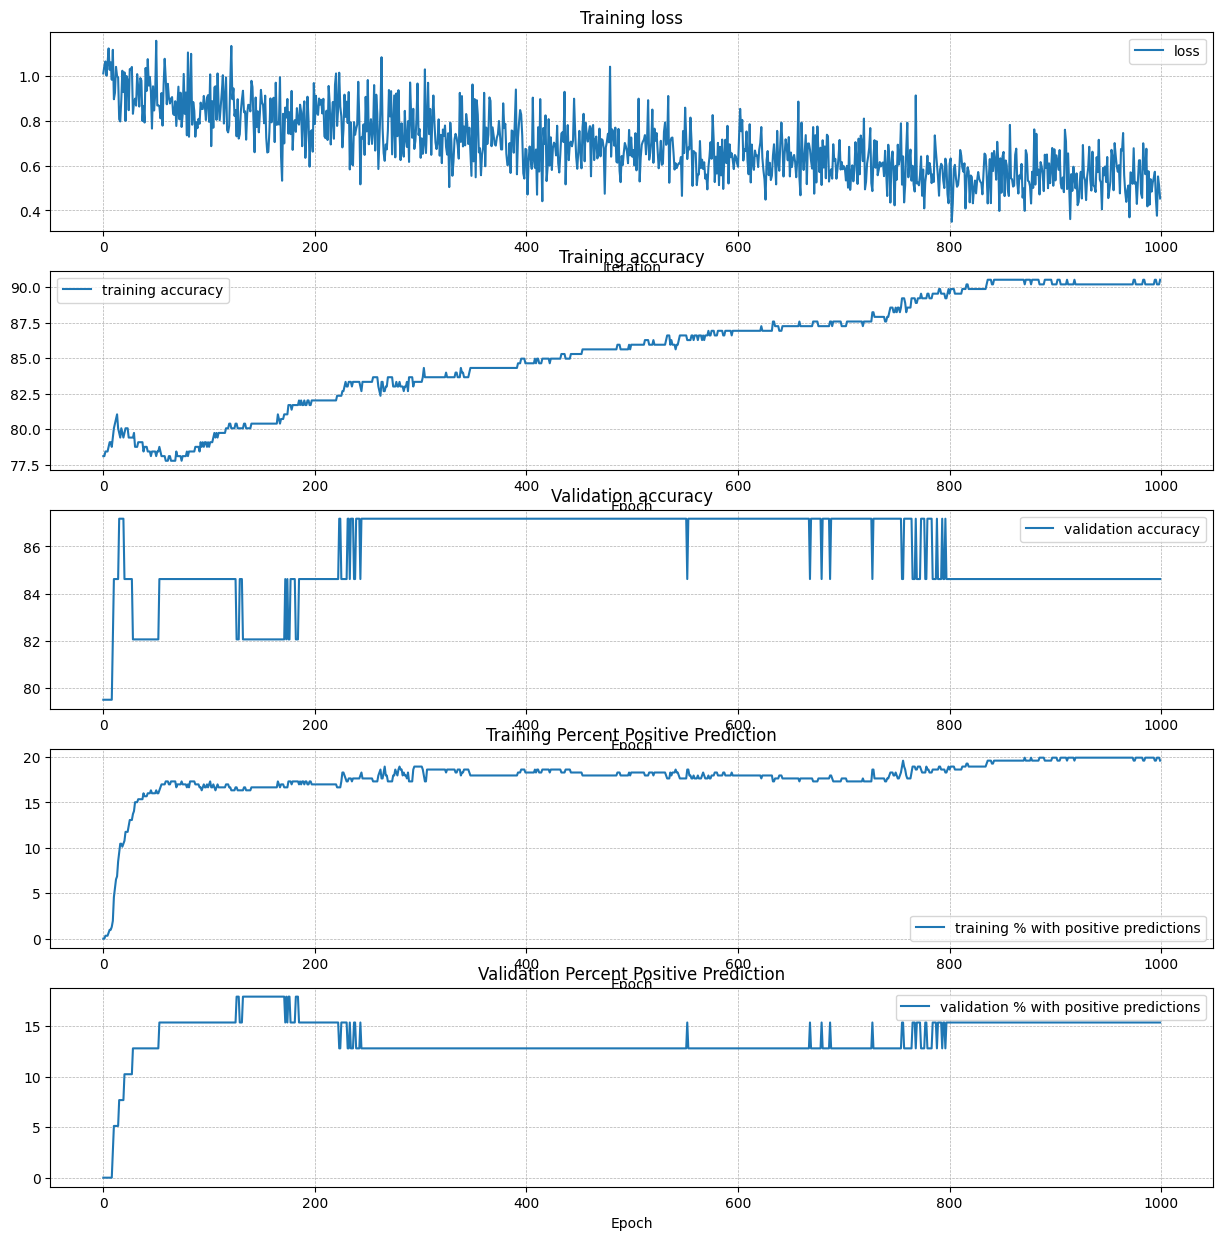

Finished running for lr: 1e-06, hidden size: 100, epochs: 1000
Epoch 0, loss = 0.9979, train_acc = 78.4314, val_acc = 82.0513, train_pos = 0.9804, val_pos = 2.5641
Epoch 0, Average Validation F1 Score: 0.2222222222222222
Epoch 10, loss = 0.8187, train_acc = 79.0850, val_acc = 84.6154, train_pos = 17.9739, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.8751, train_acc = 81.3725, val_acc = 84.6154, train_pos = 18.3007, val_pos = 15.3846
Epoch 20, Average Validation F1 Score: 0.5714285714285715
Epoch 30, loss = 0.9953, train_acc = 83.0065, val_acc = 87.1795, train_pos = 18.6275, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.6153846153846154
Epoch 40, loss = 0.6013, train_acc = 83.3333, val_acc = 79.4872, train_pos = 19.6078, val_pos = 20.5128
Epoch 40, Average Validation F1 Score: 0.5


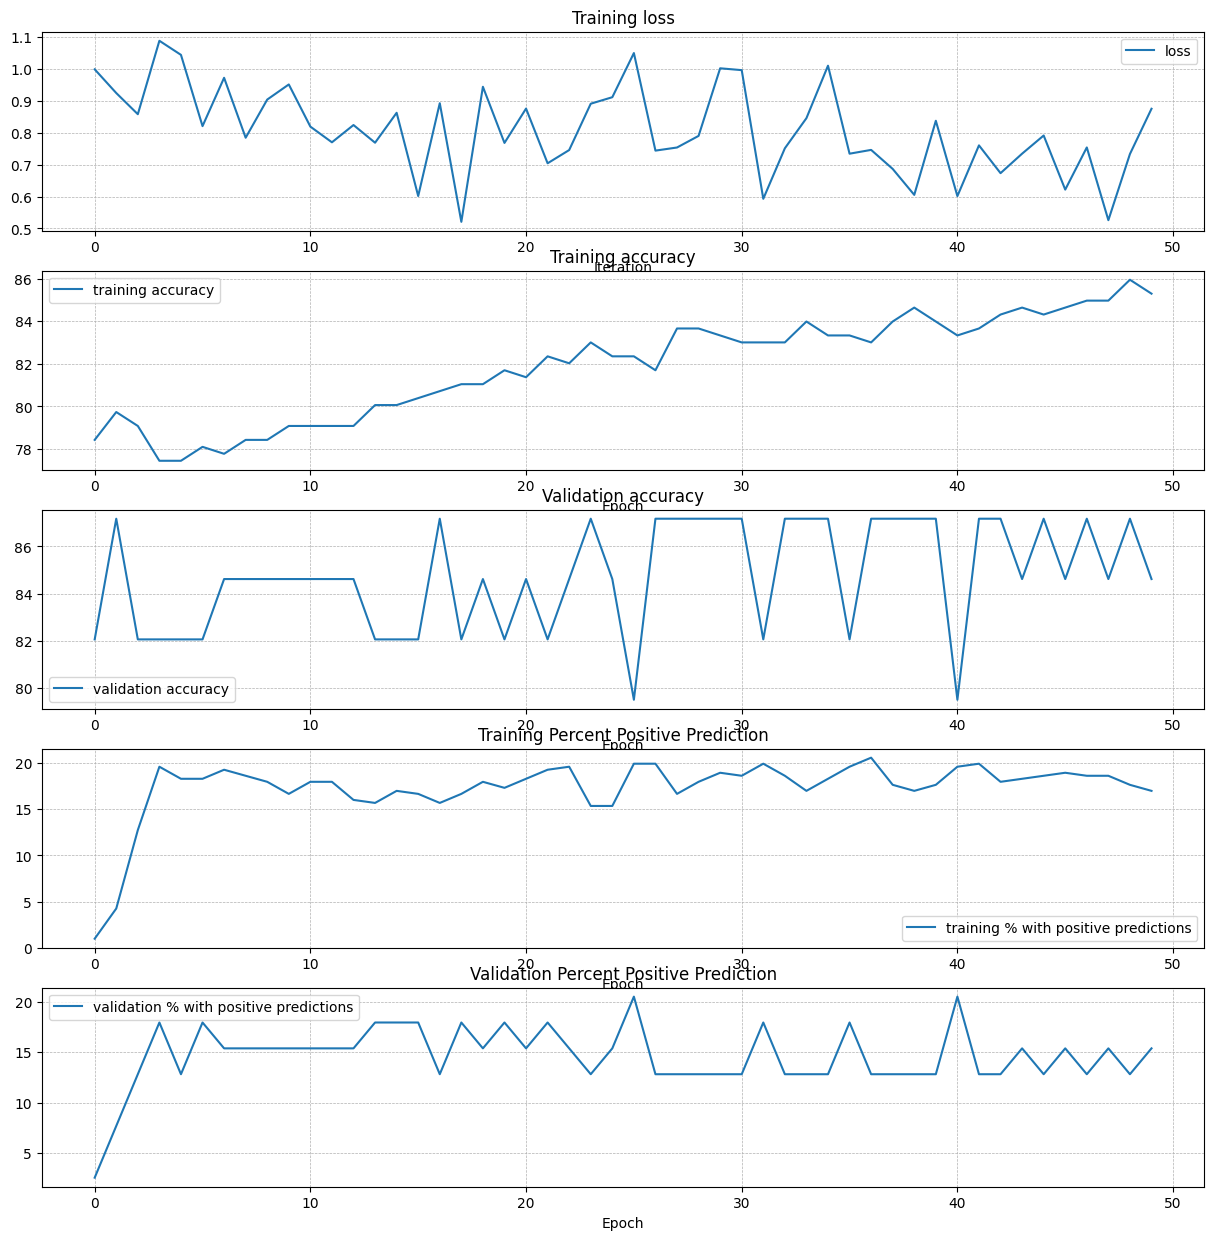

Finished running for lr: 1e-05, hidden size: 100, epochs: 50
Epoch 0, loss = 1.0886, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.7931, train_acc = 78.1046, val_acc = 84.6154, train_pos = 16.9935, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.7511, train_acc = 79.7386, val_acc = 89.7436, train_pos = 17.3203, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.6666666666666666
Epoch 30, loss = 0.8181, train_acc = 82.6797, val_acc = 87.1795, train_pos = 16.3399, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.6153846153846154
Epoch 40, loss = 0.7223, train_acc = 82.6797, val_acc = 87.1795, train_pos = 19.6078, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.6153846153846154
Epoch 50, loss = 0.7137, train_acc = 83.9869, val_acc = 87.1795, train_pos = 19.6078, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.615

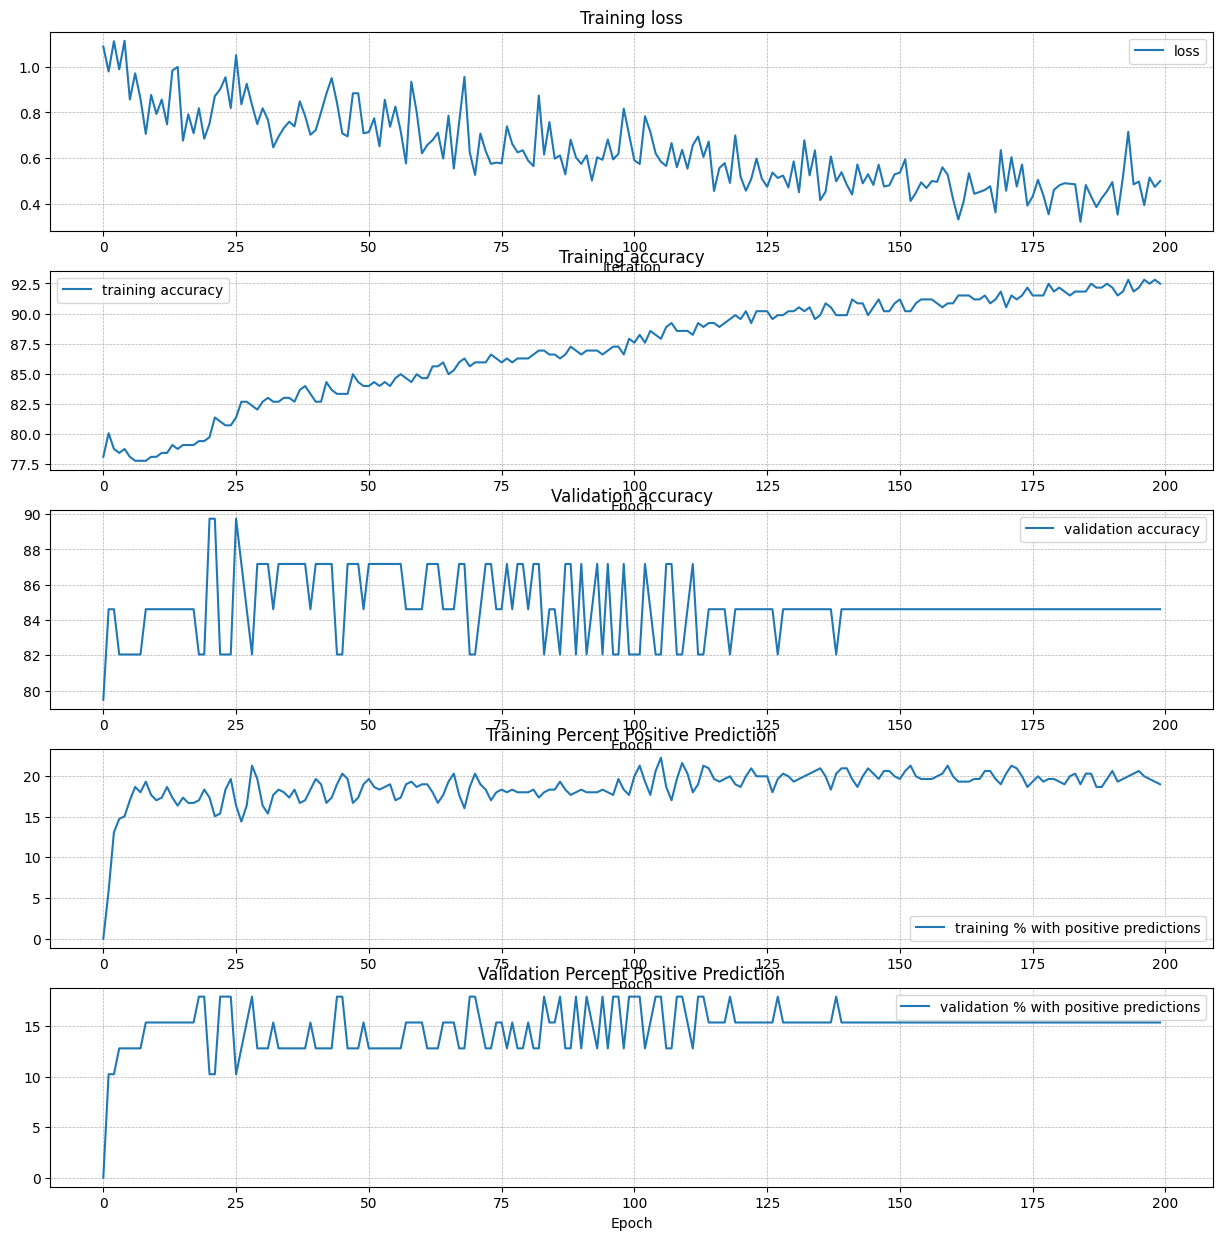

Finished running for lr: 1e-05, hidden size: 100, epochs: 200
Epoch 0, loss = 1.1569, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 1.0496, train_acc = 79.7386, val_acc = 87.1795, train_pos = 16.6667, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.6153846153846154
Epoch 20, loss = 0.8237, train_acc = 79.4118, val_acc = 87.1795, train_pos = 16.9935, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.6153846153846154
Epoch 30, loss = 0.7498, train_acc = 82.6797, val_acc = 87.1795, train_pos = 17.6471, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.6153846153846154
Epoch 40, loss = 0.5826, train_acc = 83.9869, val_acc = 87.1795, train_pos = 17.6471, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.6153846153846154
Epoch 50, loss = 0.6021, train_acc = 83.9869, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.57

Epoch 500, loss = 0.1777, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 500, Average Validation F1 Score: 0.5714285714285715
Epoch 510, loss = 0.1751, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 510, Average Validation F1 Score: 0.5714285714285715
Epoch 520, loss = 0.1445, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 520, Average Validation F1 Score: 0.5714285714285715
Epoch 530, loss = 0.1098, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 530, Average Validation F1 Score: 0.5714285714285715
Epoch 540, loss = 0.1368, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 540, Average Validation F1 Score: 0.5714285714285715
Epoch 550, loss = 0.1576, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 550, Average Validation F1 Score: 0.5714285714285715
Epoch 560, loss 

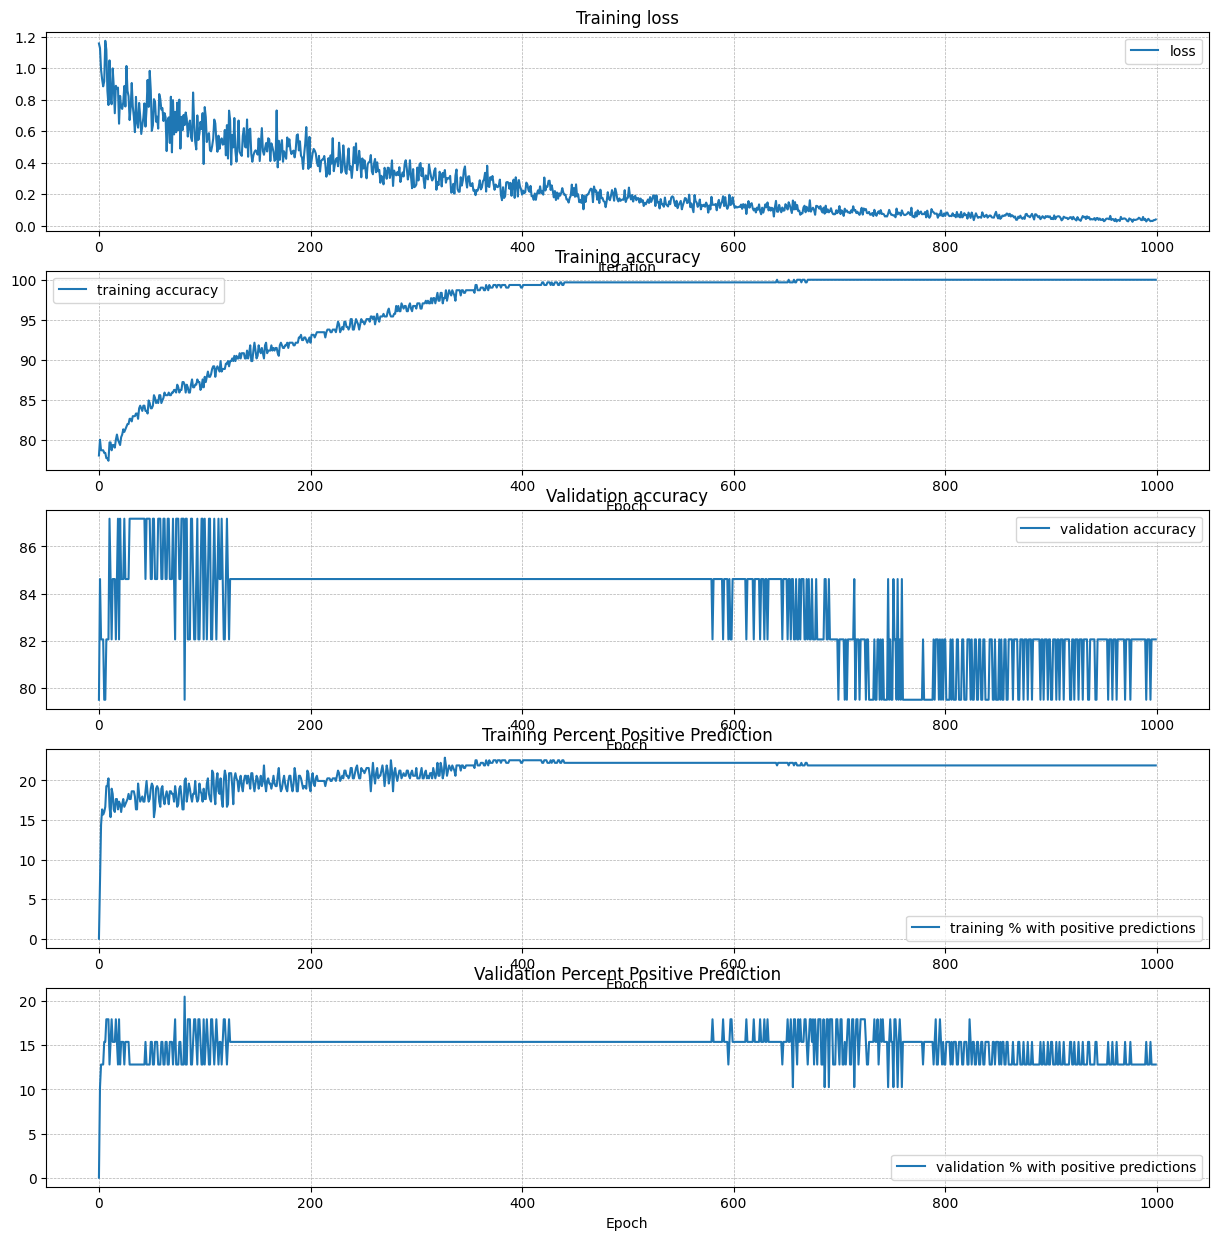

Finished running for lr: 1e-05, hidden size: 100, epochs: 1000
Epoch 0, loss = 0.9936, train_acc = 68.6275, val_acc = 84.6154, train_pos = 25.1634, val_pos = 5.1282
Epoch 0, Average Validation F1 Score: 0.4
Epoch 10, loss = 0.7412, train_acc = 84.6405, val_acc = 82.0513, train_pos = 18.3007, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.5333333333333333
Epoch 20, loss = 0.6863, train_acc = 88.8889, val_acc = 87.1795, train_pos = 16.6667, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.6153846153846154
Epoch 30, loss = 0.5567, train_acc = 90.5229, val_acc = 84.6154, train_pos = 15.6863, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.4173, train_acc = 89.8693, val_acc = 84.6154, train_pos = 27.4510, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715


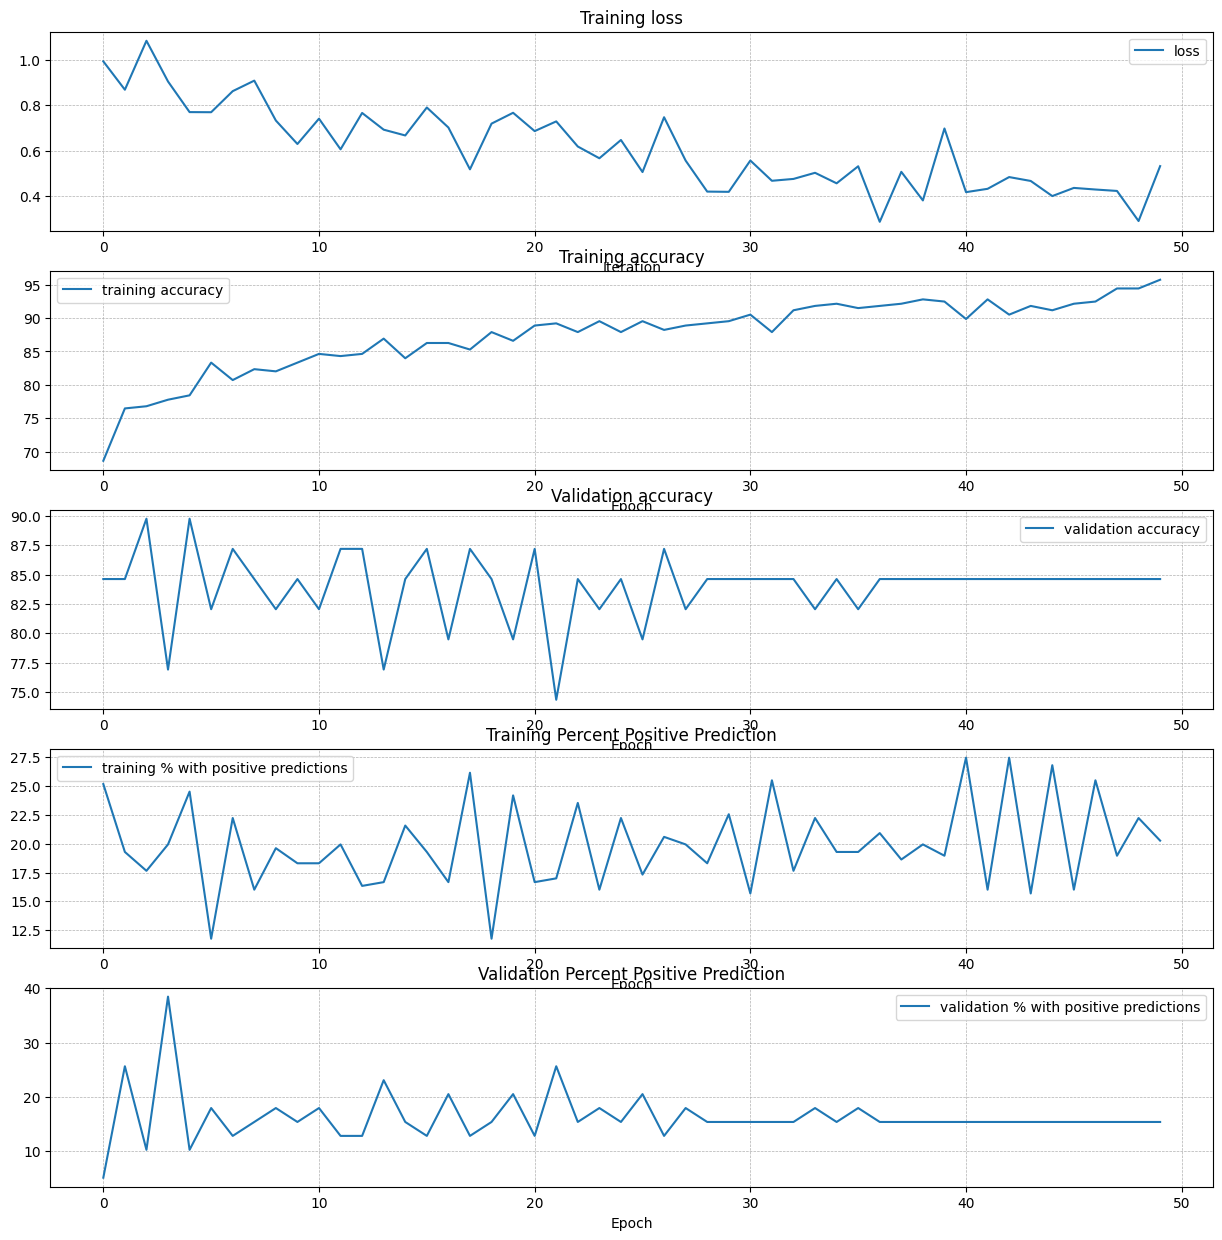

Finished running for lr: 0.0001, hidden size: 100, epochs: 50
Epoch 0, loss = 1.5153, train_acc = 77.1242, val_acc = 74.3590, train_pos = 12.7451, val_pos = 35.8974
Epoch 0, Average Validation F1 Score: 0.5454545454545454
Epoch 10, loss = 0.8339, train_acc = 85.2941, val_acc = 79.4872, train_pos = 16.3399, val_pos = 20.5128
Epoch 10, Average Validation F1 Score: 0.5
Epoch 20, loss = 0.6008, train_acc = 87.9085, val_acc = 84.6154, train_pos = 13.0719, val_pos = 15.3846
Epoch 20, Average Validation F1 Score: 0.5714285714285715
Epoch 30, loss = 0.5541, train_acc = 87.5817, val_acc = 84.6154, train_pos = 27.7778, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.3440, train_acc = 93.4641, val_acc = 84.6154, train_pos = 22.5490, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715
Epoch 50, loss = 0.3449, train_acc = 96.0784, val_acc = 82.0513, train_pos = 25.1634, val_pos = 17.9487
Epoch 50, Average Validation F1 Score: 0.

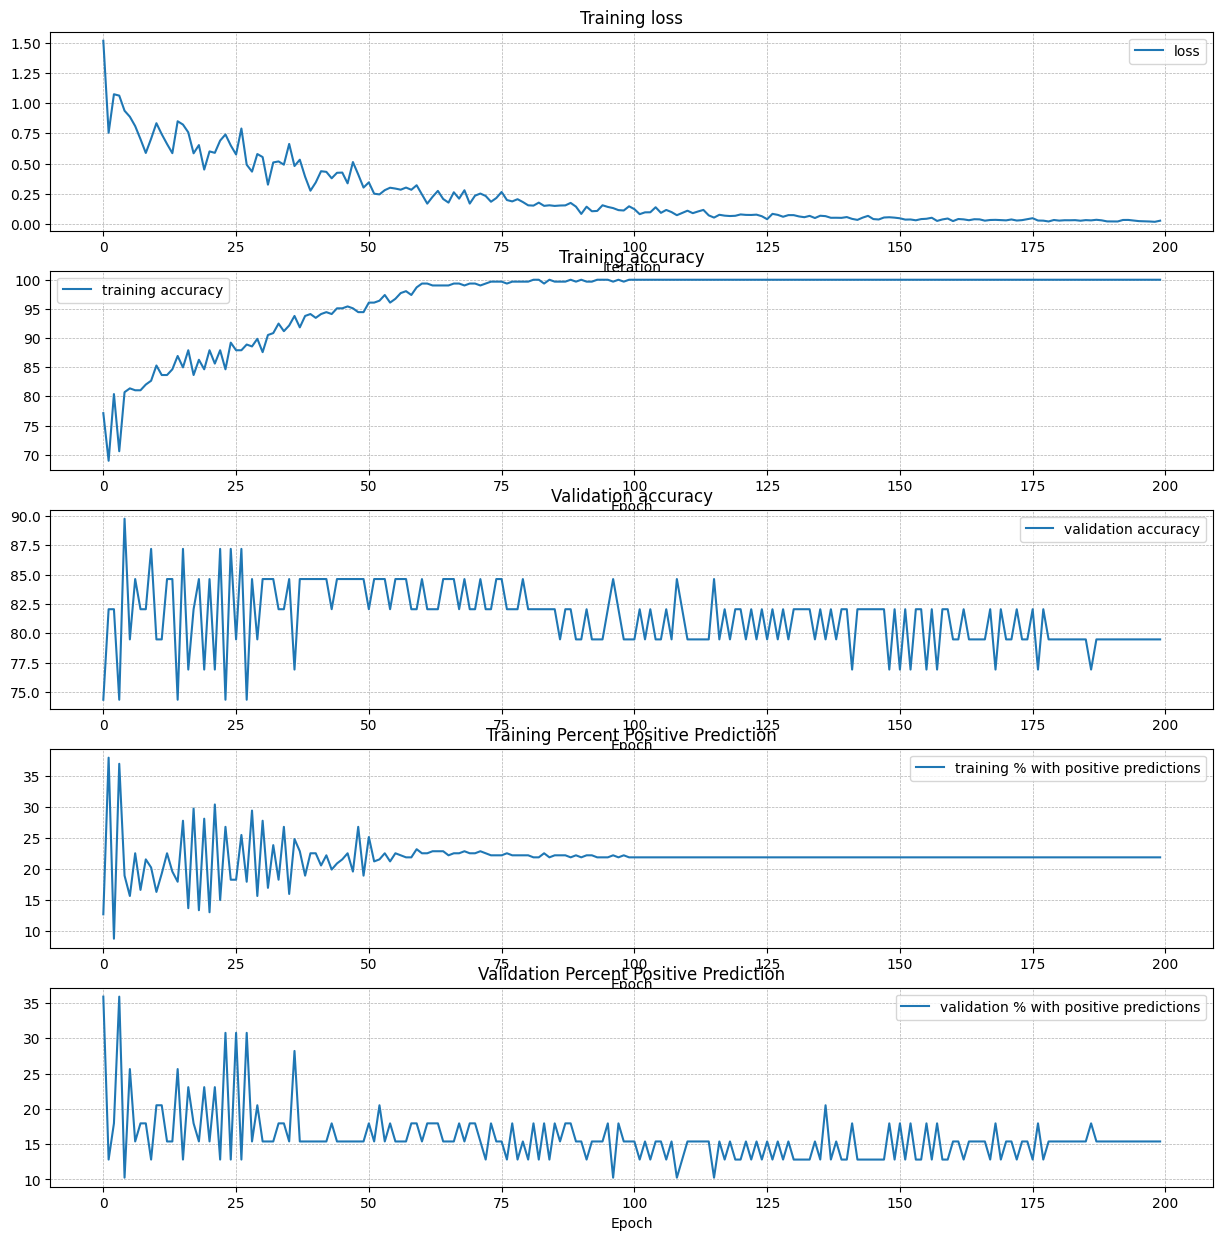

Finished running for lr: 0.0001, hidden size: 100, epochs: 200
Epoch 0, loss = 0.9510, train_acc = 72.5490, val_acc = 79.4872, train_pos = 19.2810, val_pos = 30.7692
Epoch 0, Average Validation F1 Score: 0.6
Epoch 10, loss = 0.6701, train_acc = 82.6797, val_acc = 84.6154, train_pos = 18.9542, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.5706, train_acc = 87.9085, val_acc = 79.4872, train_pos = 20.9150, val_pos = 20.5128
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.4907, train_acc = 90.5229, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.3150, train_acc = 94.7712, val_acc = 76.9231, train_pos = 19.2810, val_pos = 23.0769
Epoch 40, Average Validation F1 Score: 0.47058823529411764
Epoch 50, loss = 0.3781, train_acc = 96.7320, val_acc = 84.6154, train_pos = 21.2418, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.5714285714285

Epoch 500, loss = 0.0021, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 500, Average Validation F1 Score: 0.3076923076923077
Epoch 510, loss = 0.0025, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 510, Average Validation F1 Score: 0.3076923076923077
Epoch 520, loss = 0.0025, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 520, Average Validation F1 Score: 0.3076923076923077
Epoch 530, loss = 0.0017, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 530, Average Validation F1 Score: 0.3076923076923077
Epoch 540, loss = 0.0024, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 540, Average Validation F1 Score: 0.3076923076923077
Epoch 550, loss = 0.0014, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 12.8205
Epoch 550, Average Validation F1 Score: 0.3076923076923077
Epoch 560,

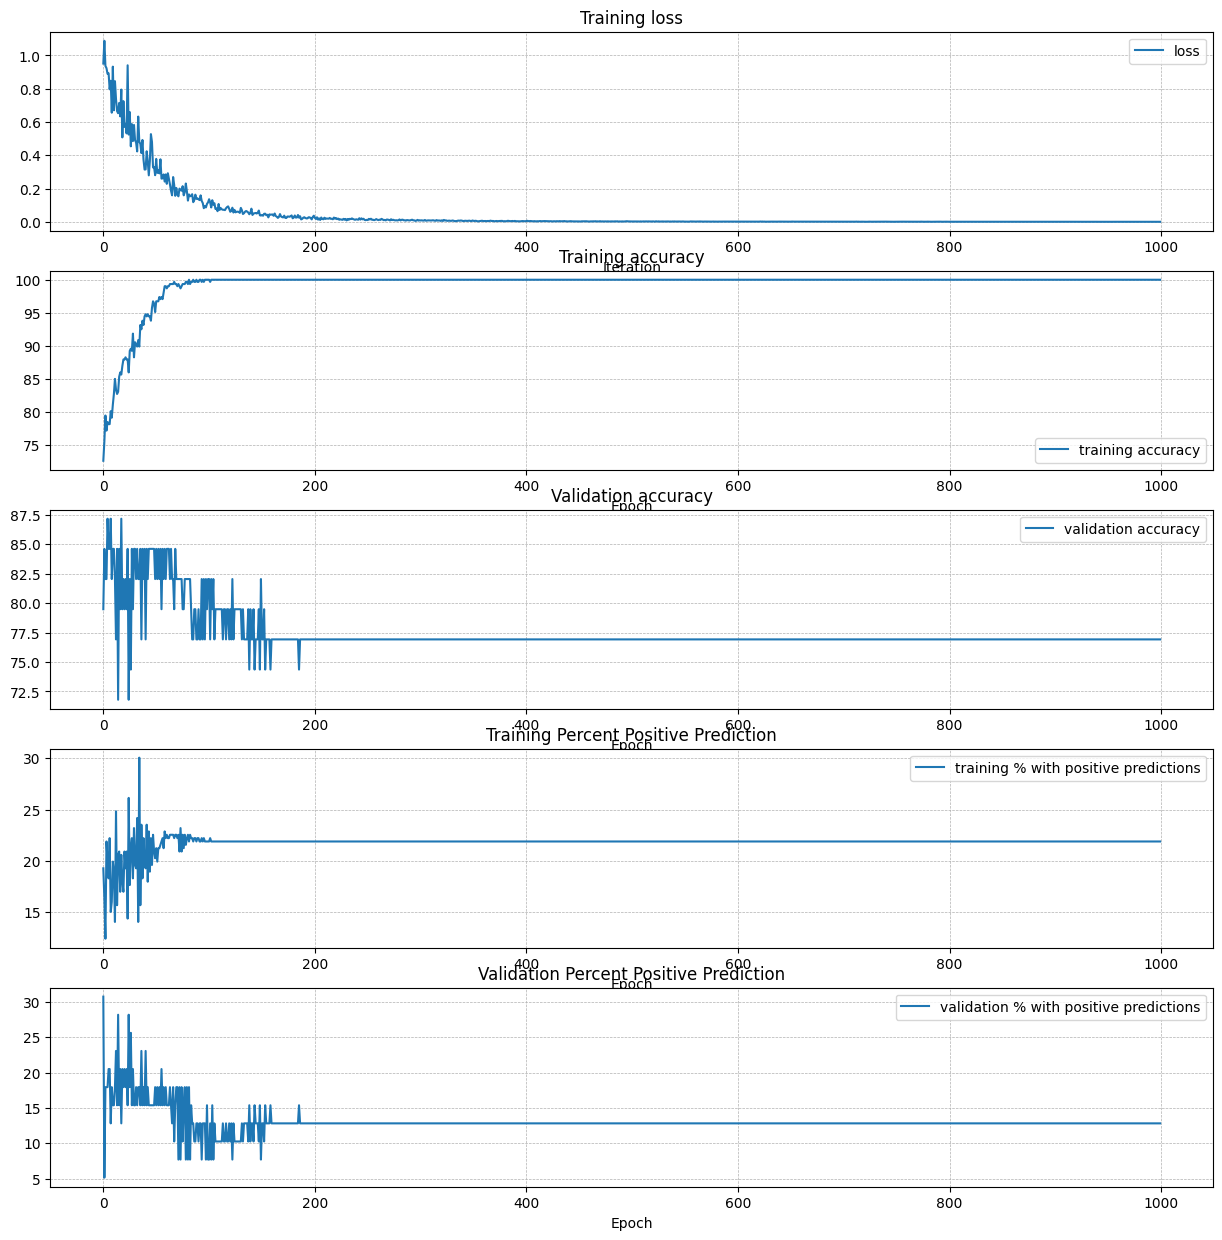

Finished running for lr: 0.0001, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.7282, train_acc = 66.0131, val_acc = 30.7692, train_pos = 27.7778, val_pos = 89.7436
Epoch 0, Average Validation F1 Score: 0.3720930232558139
Epoch 10, loss = 0.4577, train_acc = 87.9085, val_acc = 87.1795, train_pos = 24.8366, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.6153846153846154
Epoch 20, loss = 0.3023, train_acc = 94.7712, val_acc = 82.0513, train_pos = 25.1634, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.4615384615384615
Epoch 30, loss = 0.2167, train_acc = 99.0196, val_acc = 84.6154, train_pos = 22.8758, val_pos = 10.2564
Epoch 30, Average Validation F1 Score: 0.5
Epoch 40, loss = 0.1164, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 40, Average Validation F1 Score: 0.5


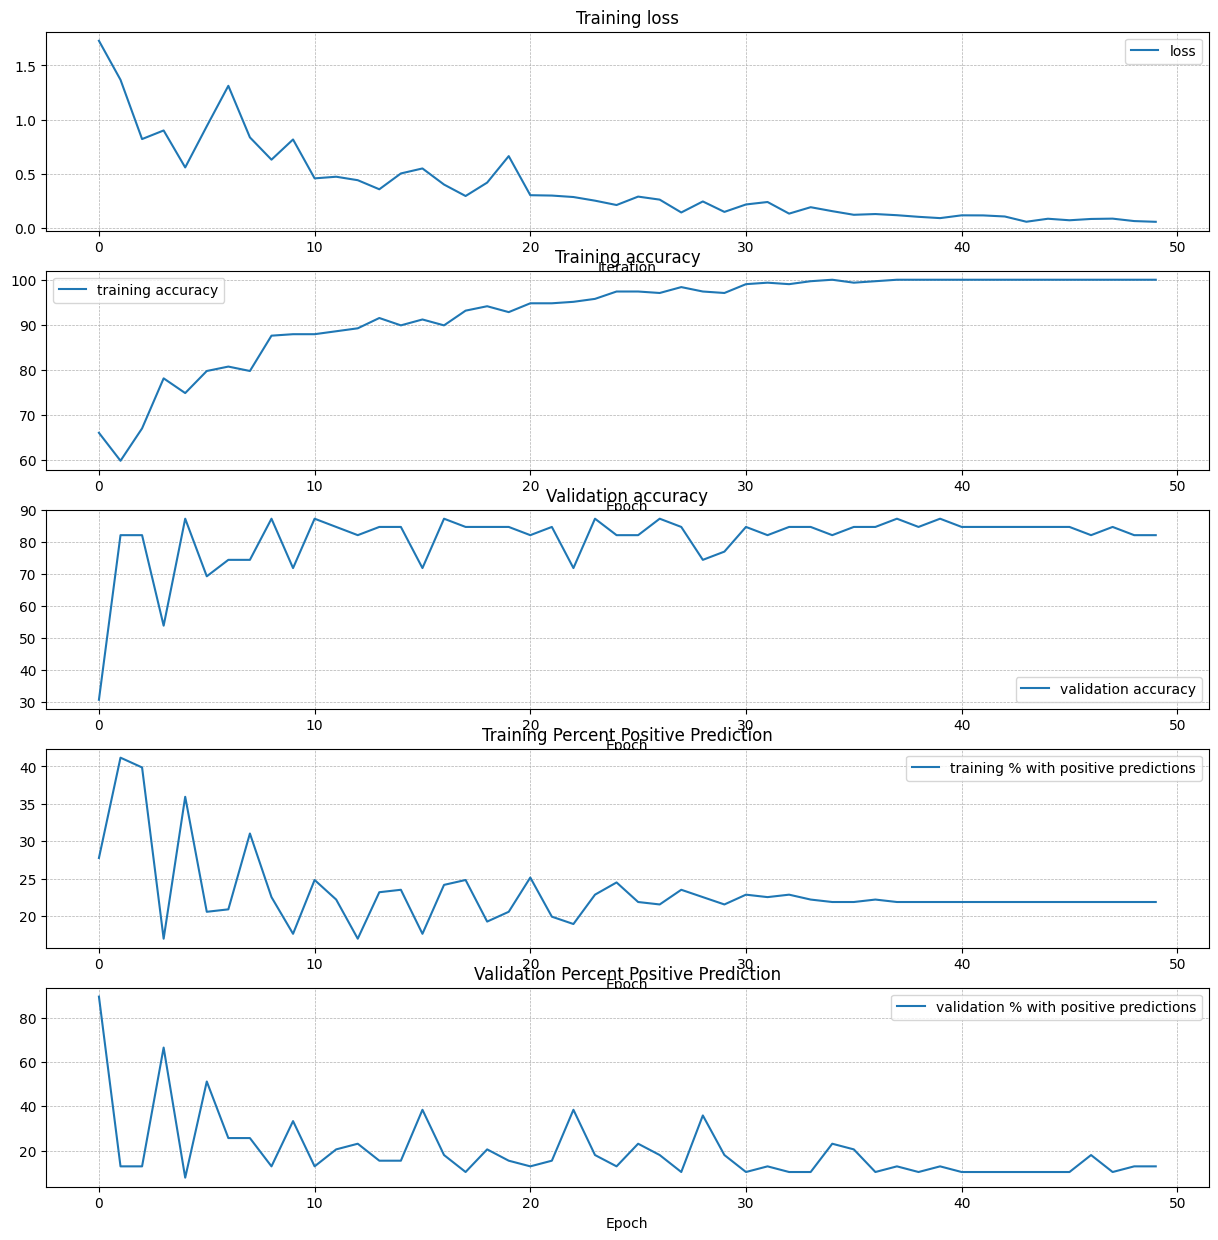

Finished running for lr: 0.001, hidden size: 100, epochs: 50
Epoch 0, loss = 1.3216, train_acc = 52.6144, val_acc = 82.0513, train_pos = 49.6732, val_pos = 23.0769
Epoch 0, Average Validation F1 Score: 0.5882352941176471
Epoch 10, loss = 0.6628, train_acc = 85.6209, val_acc = 82.0513, train_pos = 18.6275, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.5333333333333333
Epoch 20, loss = 0.5603, train_acc = 92.1569, val_acc = 71.7949, train_pos = 23.2026, val_pos = 33.3333
Epoch 20, Average Validation F1 Score: 0.4761904761904762
Epoch 30, loss = 0.3487, train_acc = 94.1176, val_acc = 66.6667, train_pos = 19.9346, val_pos = 48.7179
Epoch 30, Average Validation F1 Score: 0.5185185185185185
Epoch 40, loss = 0.1263, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 40, Average Validation F1 Score: 0.5
Epoch 50, loss = 0.0733, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 50, Average Validation F1 Score: 0.

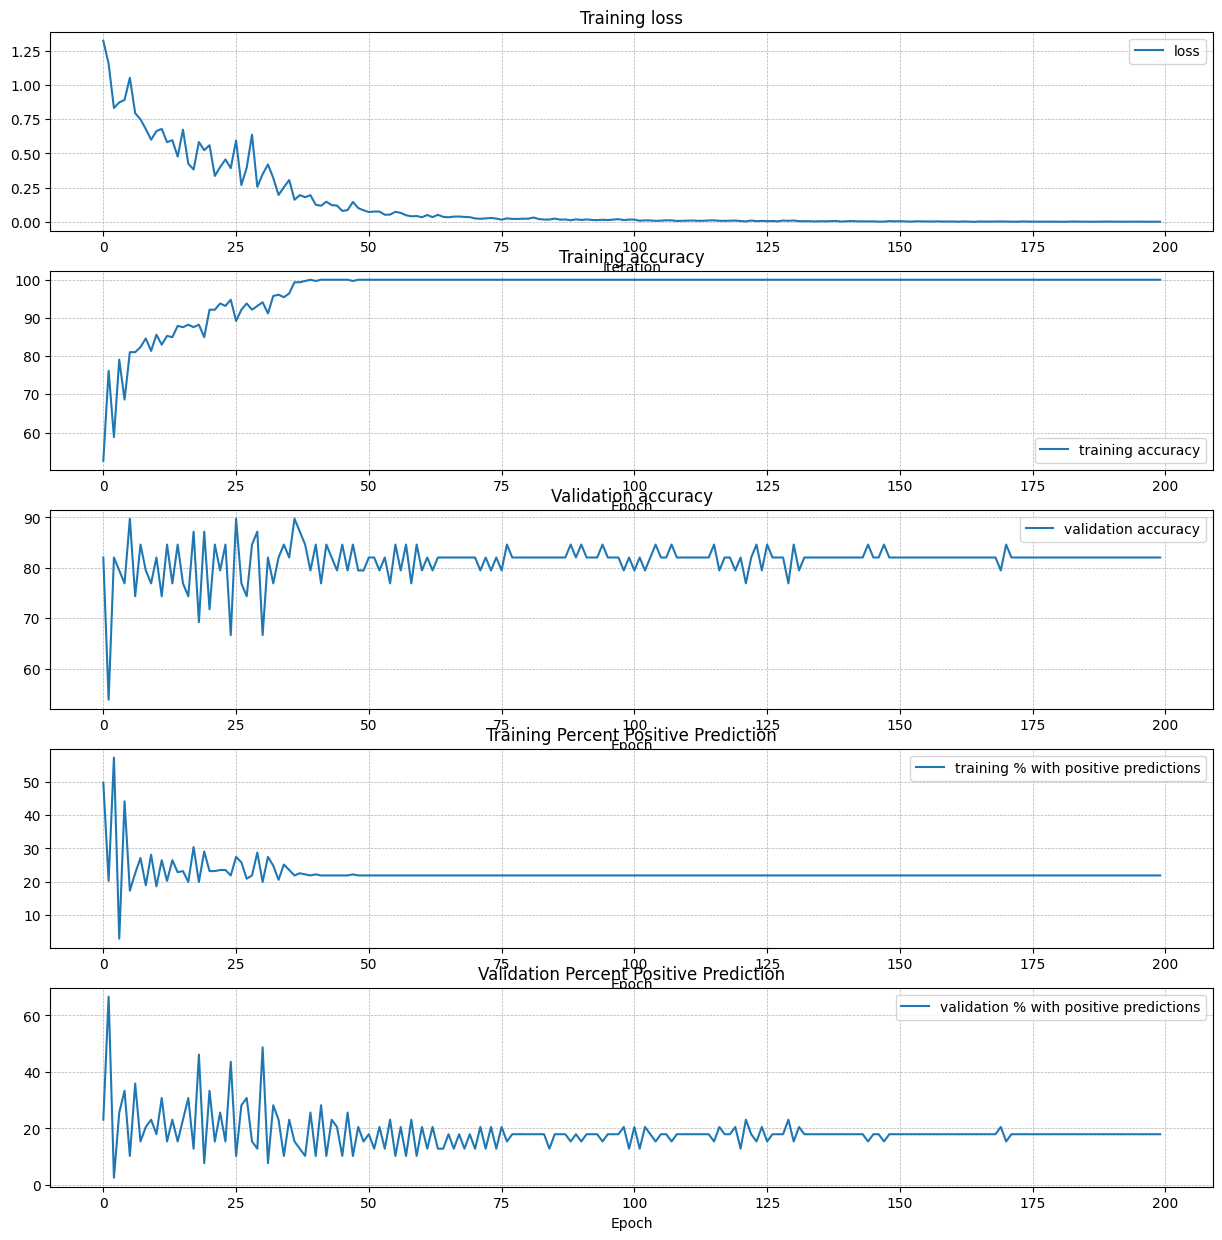

Finished running for lr: 0.001, hidden size: 100, epochs: 200
Epoch 0, loss = 1.7907, train_acc = 61.1111, val_acc = 41.0256, train_pos = 30.0654, val_pos = 79.4872
Epoch 0, Average Validation F1 Score: 0.41025641025641024
Epoch 10, loss = 0.5587, train_acc = 88.8889, val_acc = 84.6154, train_pos = 17.9739, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.3617, train_acc = 95.0980, val_acc = 71.7949, train_pos = 21.5686, val_pos = 33.3333
Epoch 20, Average Validation F1 Score: 0.4761904761904762
Epoch 30, loss = 0.2434, train_acc = 99.0196, val_acc = 76.9231, train_pos = 22.2222, val_pos = 28.2051
Epoch 30, Average Validation F1 Score: 0.5263157894736842
Epoch 40, loss = 0.0838, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 40, Average Validation F1 Score: 0.5
Epoch 50, loss = 0.0606, train_acc = 99.6732, val_acc = 82.0513, train_pos = 22.2222, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0

Epoch 500, loss = 0.0002, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 500, Average Validation F1 Score: 0.39999999999999997
Epoch 510, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 510, Average Validation F1 Score: 0.39999999999999997
Epoch 520, loss = 0.0003, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 520, Average Validation F1 Score: 0.42857142857142855
Epoch 530, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 530, Average Validation F1 Score: 0.39999999999999997
Epoch 540, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 540, Average Validation F1 Score: 0.39999999999999997
Epoch 550, loss = 0.0003, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 550, Average Validation F1 Score: 0.39999999999999997
Epoc

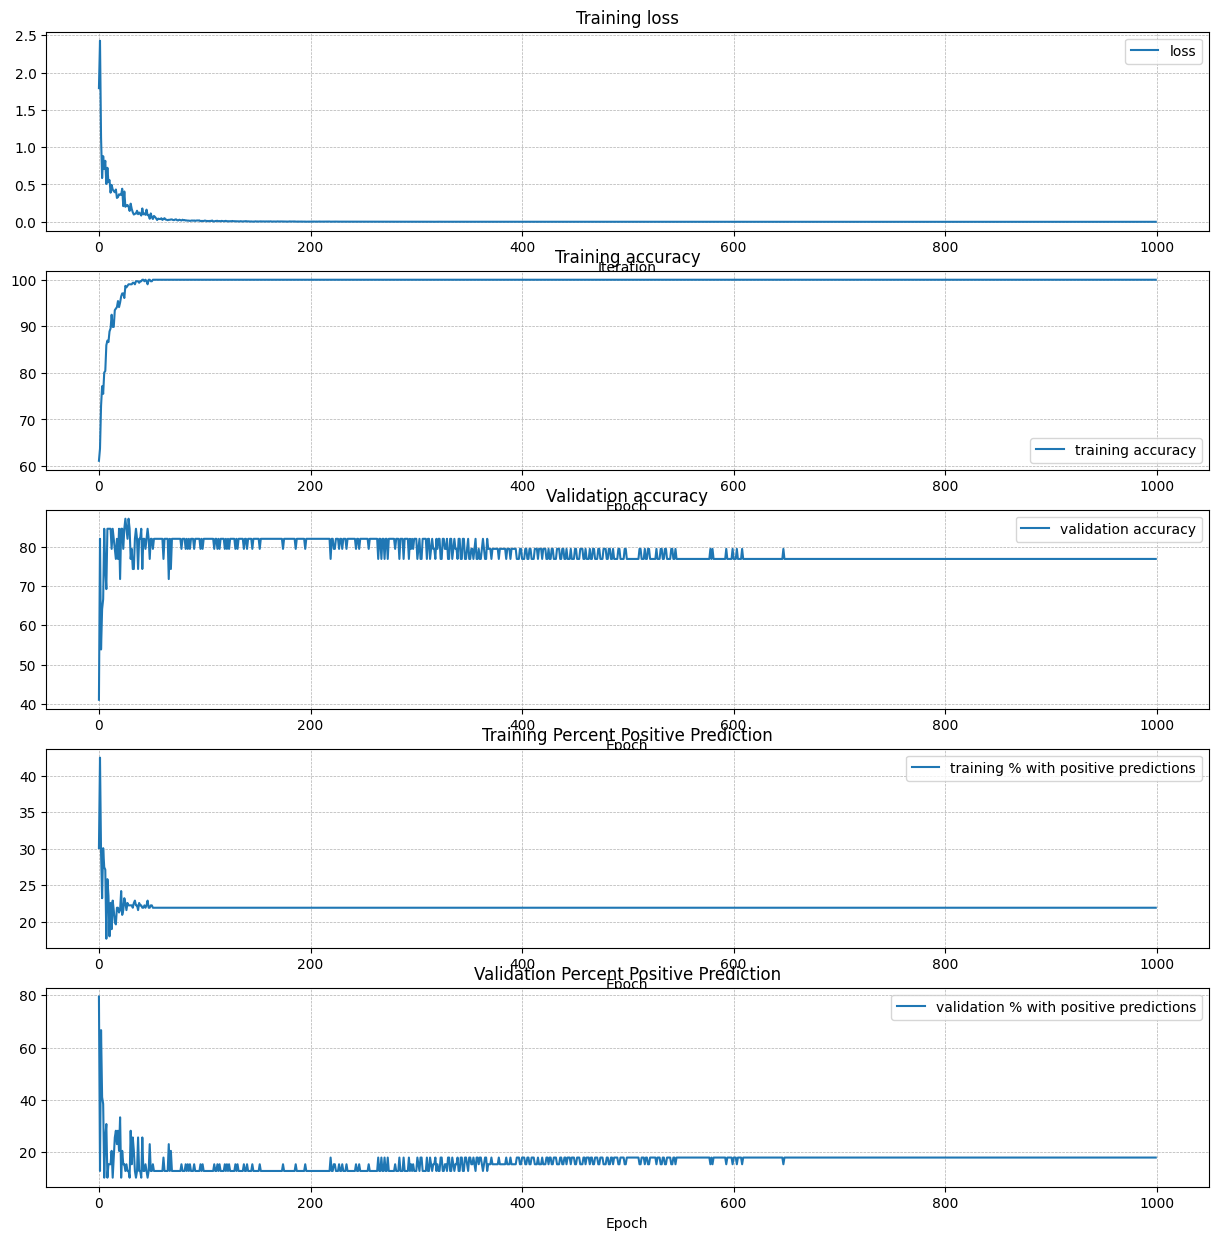

Finished running for lr: 0.001, hidden size: 100, epochs: 1000
Epoch 0, loss = 32.6557, train_acc = 51.6340, val_acc = 79.4872, train_pos = 42.1569, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.7079, train_acc = 81.0458, val_acc = 84.6154, train_pos = 11.4379, val_pos = 10.2564
Epoch 10, Average Validation F1 Score: 0.5
Epoch 20, loss = 0.6553, train_acc = 84.9673, val_acc = 84.6154, train_pos = 7.5163, val_pos = 10.2564
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.3944, train_acc = 84.3137, val_acc = 84.6154, train_pos = 10.1307, val_pos = 5.1282
Epoch 30, Average Validation F1 Score: 0.4
Epoch 40, loss = 0.3918, train_acc = 86.2745, val_acc = 84.6154, train_pos = 8.1699, val_pos = 10.2564
Epoch 40, Average Validation F1 Score: 0.5


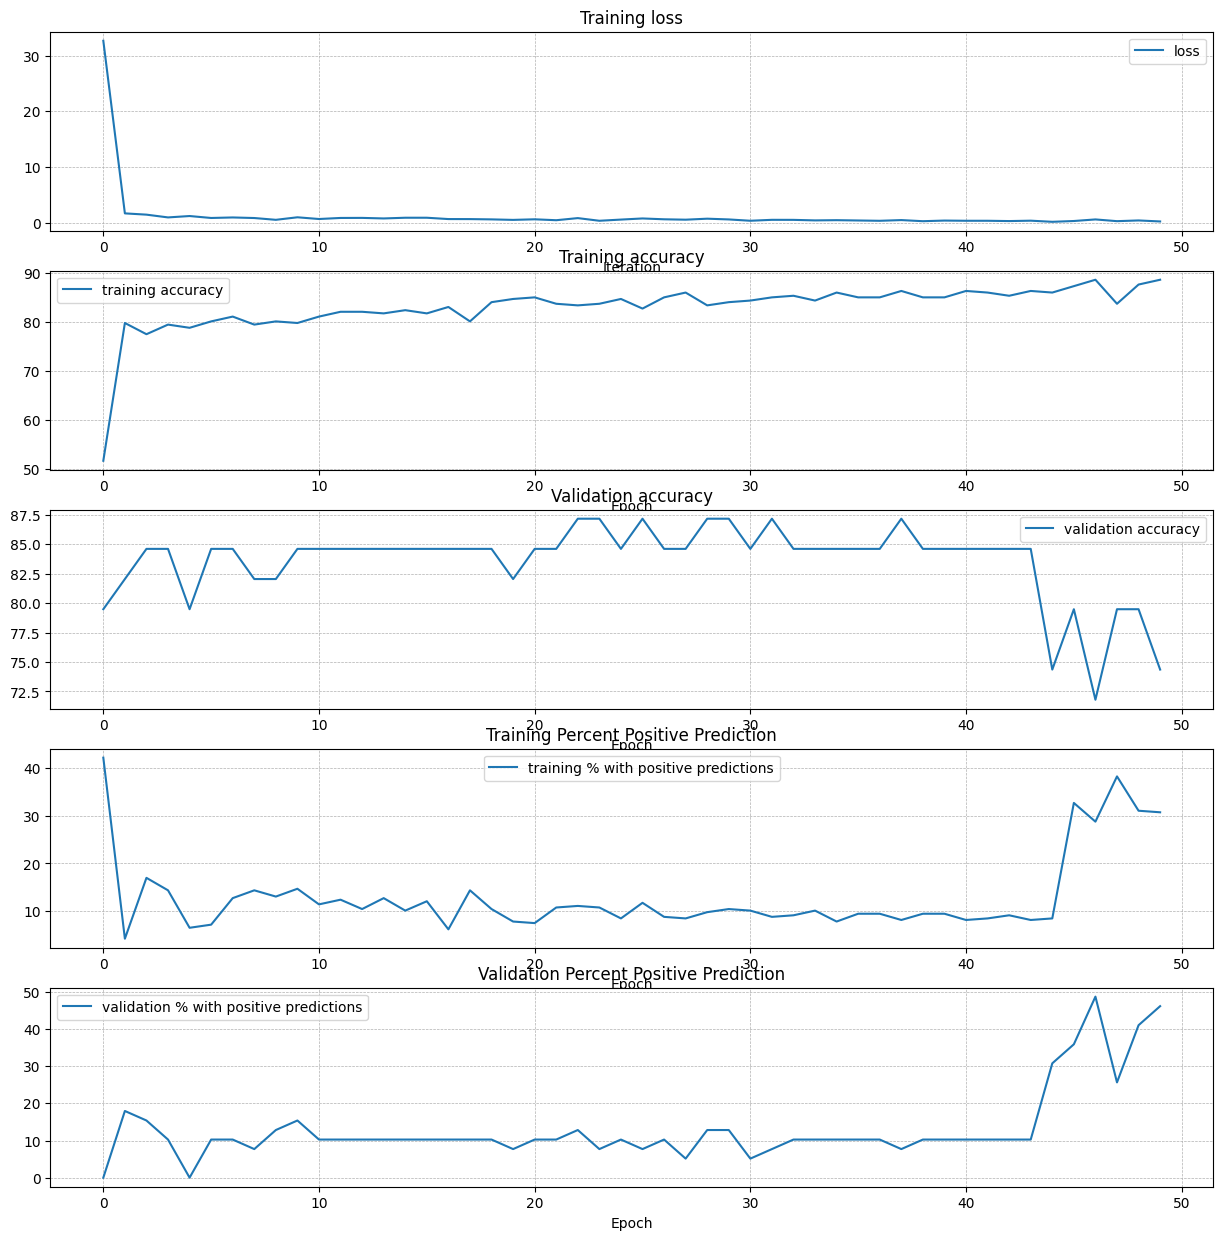

Finished running for lr: 0.01, hidden size: 100, epochs: 50
Epoch 0, loss = 44.7625, train_acc = 66.9935, val_acc = 53.8462, train_pos = 27.4510, val_pos = 51.2821
Epoch 0, Average Validation F1 Score: 0.35714285714285715
Epoch 10, loss = 0.8713, train_acc = 80.7190, val_acc = 84.6154, train_pos = 17.6471, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.6383, train_acc = 84.6405, val_acc = 69.2308, train_pos = 27.4510, val_pos = 30.7692
Epoch 20, Average Validation F1 Score: 0.4
Epoch 30, loss = 0.3656, train_acc = 86.2745, val_acc = 69.2308, train_pos = 29.7386, val_pos = 30.7692
Epoch 30, Average Validation F1 Score: 0.4
Epoch 40, loss = 0.2793, train_acc = 93.7908, val_acc = 79.4872, train_pos = 24.1830, val_pos = 20.5128
Epoch 40, Average Validation F1 Score: 0.5
Epoch 50, loss = 0.1107, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.5714285714285715
Epoch 60, los

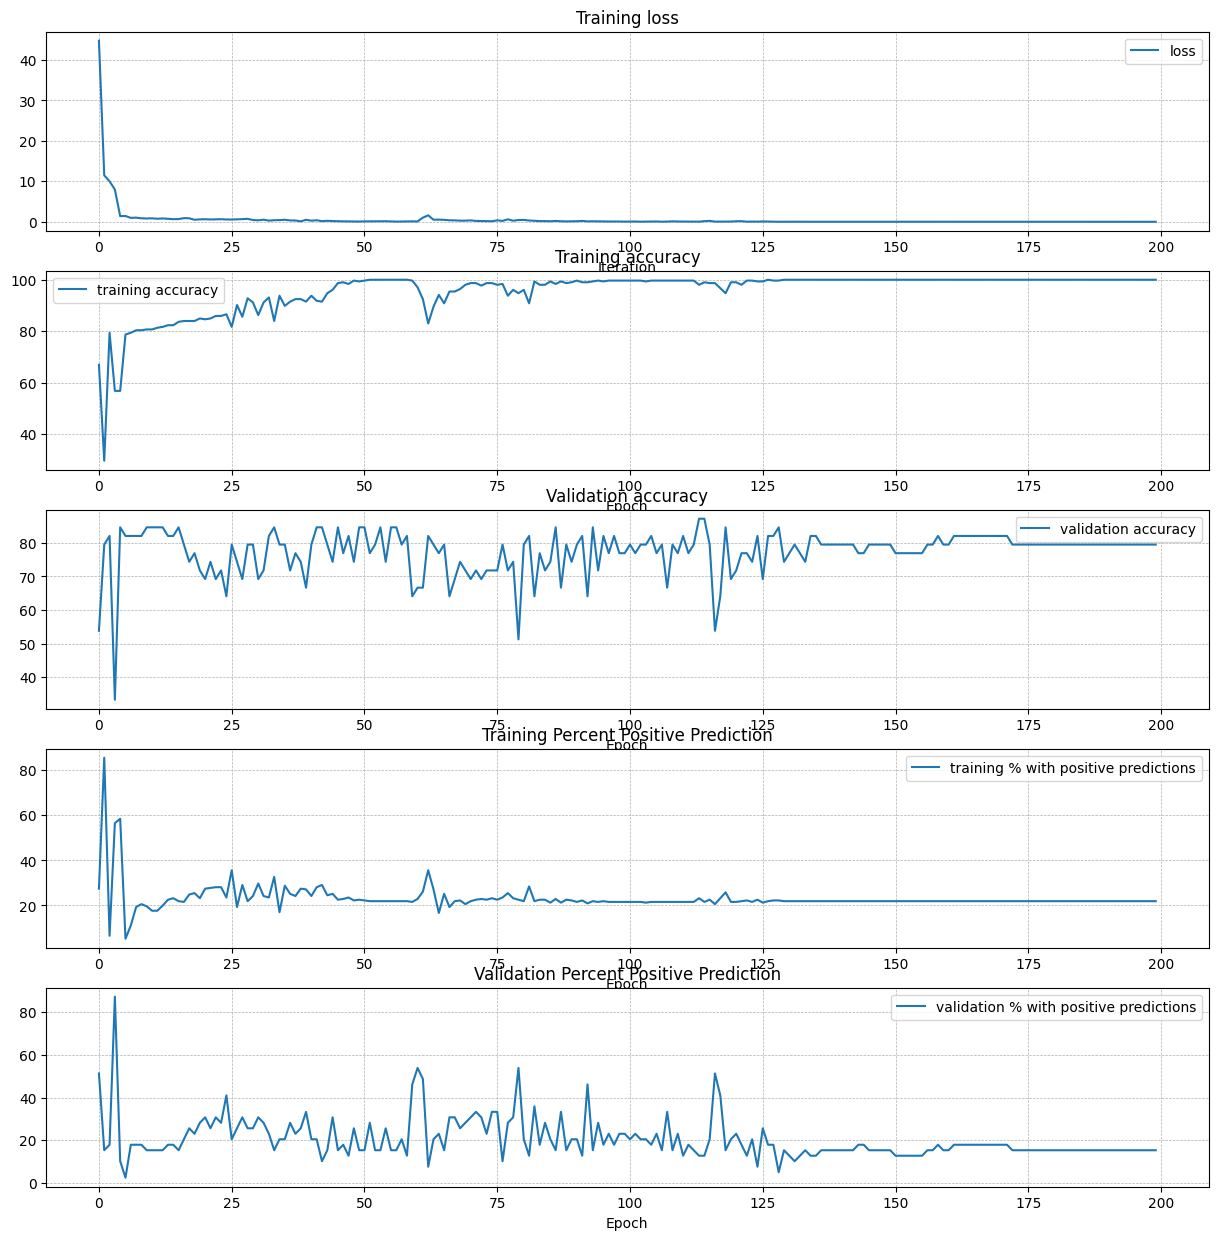

Finished running for lr: 0.01, hidden size: 100, epochs: 200
Epoch 0, loss = 14.8063, train_acc = 50.6536, val_acc = 79.4872, train_pos = 48.3660, val_pos = 10.2564
Epoch 0, Average Validation F1 Score: 0.3333333333333333
Epoch 10, loss = 0.5914, train_acc = 86.9281, val_acc = 82.0513, train_pos = 21.8954, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.5333333333333333
Epoch 20, loss = 0.3570, train_acc = 91.5033, val_acc = 66.6667, train_pos = 19.9346, val_pos = 48.7179
Epoch 20, Average Validation F1 Score: 0.5185185185185185
Epoch 30, loss = 0.1243, train_acc = 96.4052, val_acc = 84.6154, train_pos = 22.2222, val_pos = 10.2564
Epoch 30, Average Validation F1 Score: 0.5
Epoch 40, loss = 0.0486, train_acc = 100.0000, val_acc = 84.6154, train_pos = 21.8954, val_pos = 10.2564
Epoch 40, Average Validation F1 Score: 0.5
Epoch 50, loss = 0.0176, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 50, Average Validation F1 Score: 0.5
Epoch 60, l

Epoch 540, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 540, Average Validation F1 Score: 0.5
Epoch 550, loss = 0.0000, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 550, Average Validation F1 Score: 0.5
Epoch 560, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 560, Average Validation F1 Score: 0.5
Epoch 570, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 570, Average Validation F1 Score: 0.5
Epoch 580, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 580, Average Validation F1 Score: 0.5
Epoch 590, loss = 0.0001, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 590, Average Validation F1 Score: 0.5
Epoch 600, loss = 0.0000, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20

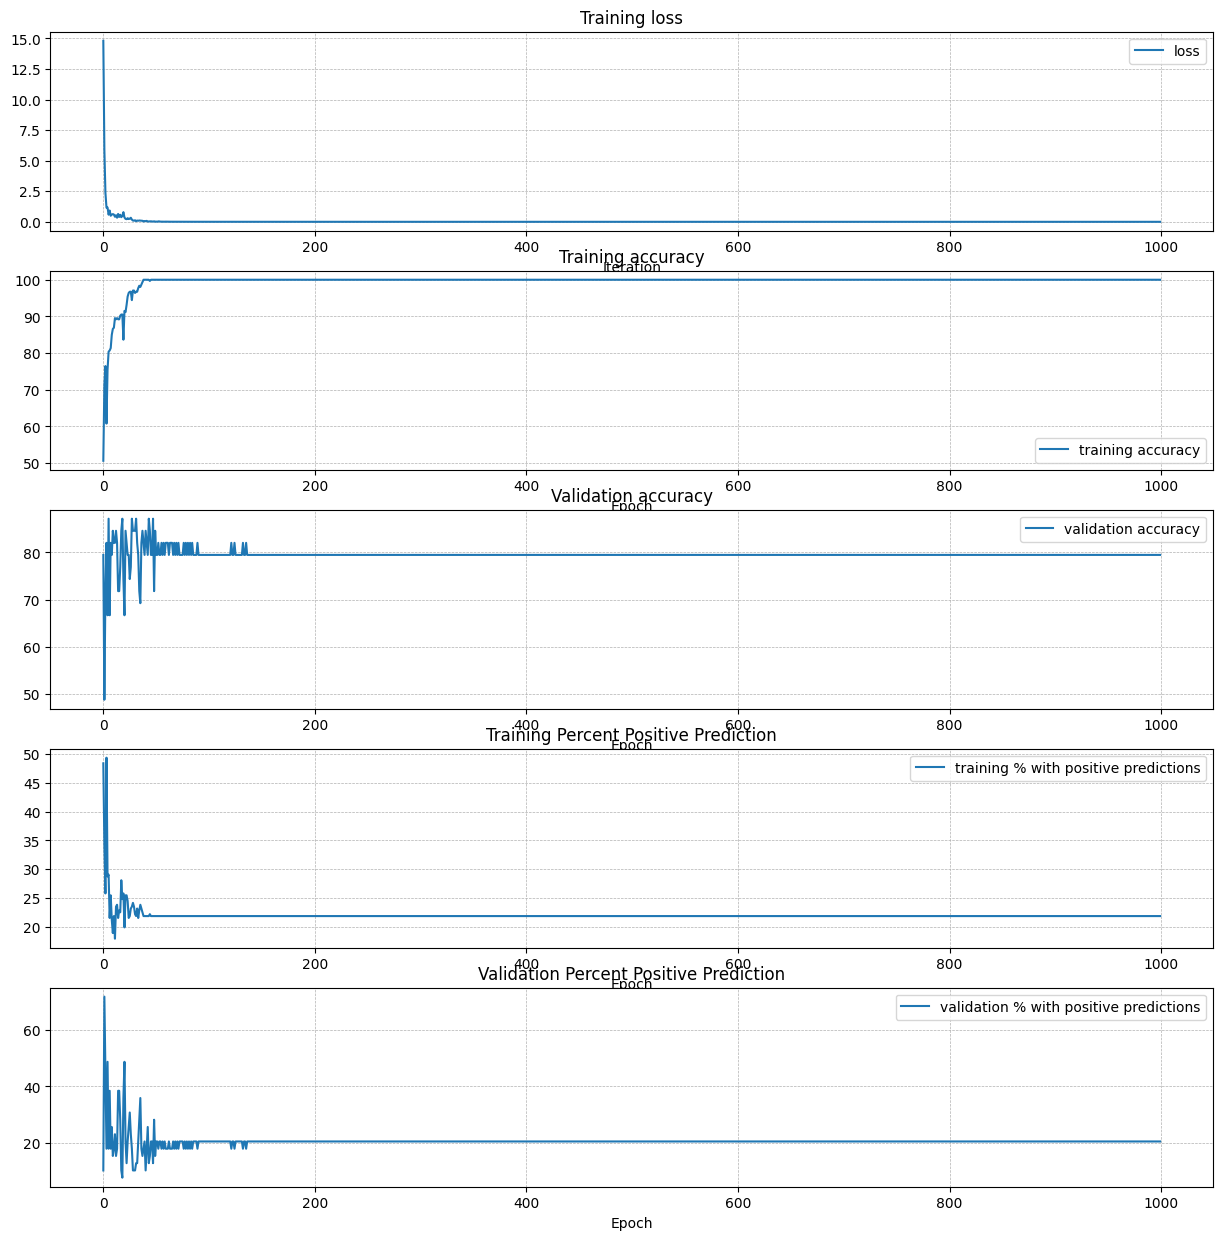

Finished running for lr: 0.01, hidden size: 100, epochs: 1000
Epoch 0, loss = 1.1299, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.9484, train_acc = 79.0850, val_acc = 82.0513, train_pos = 14.7059, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 1.0482, train_acc = 78.4314, val_acc = 82.0513, train_pos = 16.0131, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.4615384615384615
Epoch 30, loss = 1.0445, train_acc = 79.0850, val_acc = 84.6154, train_pos = 16.6667, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.8789, train_acc = 79.7386, val_acc = 84.6154, train_pos = 16.0131, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715


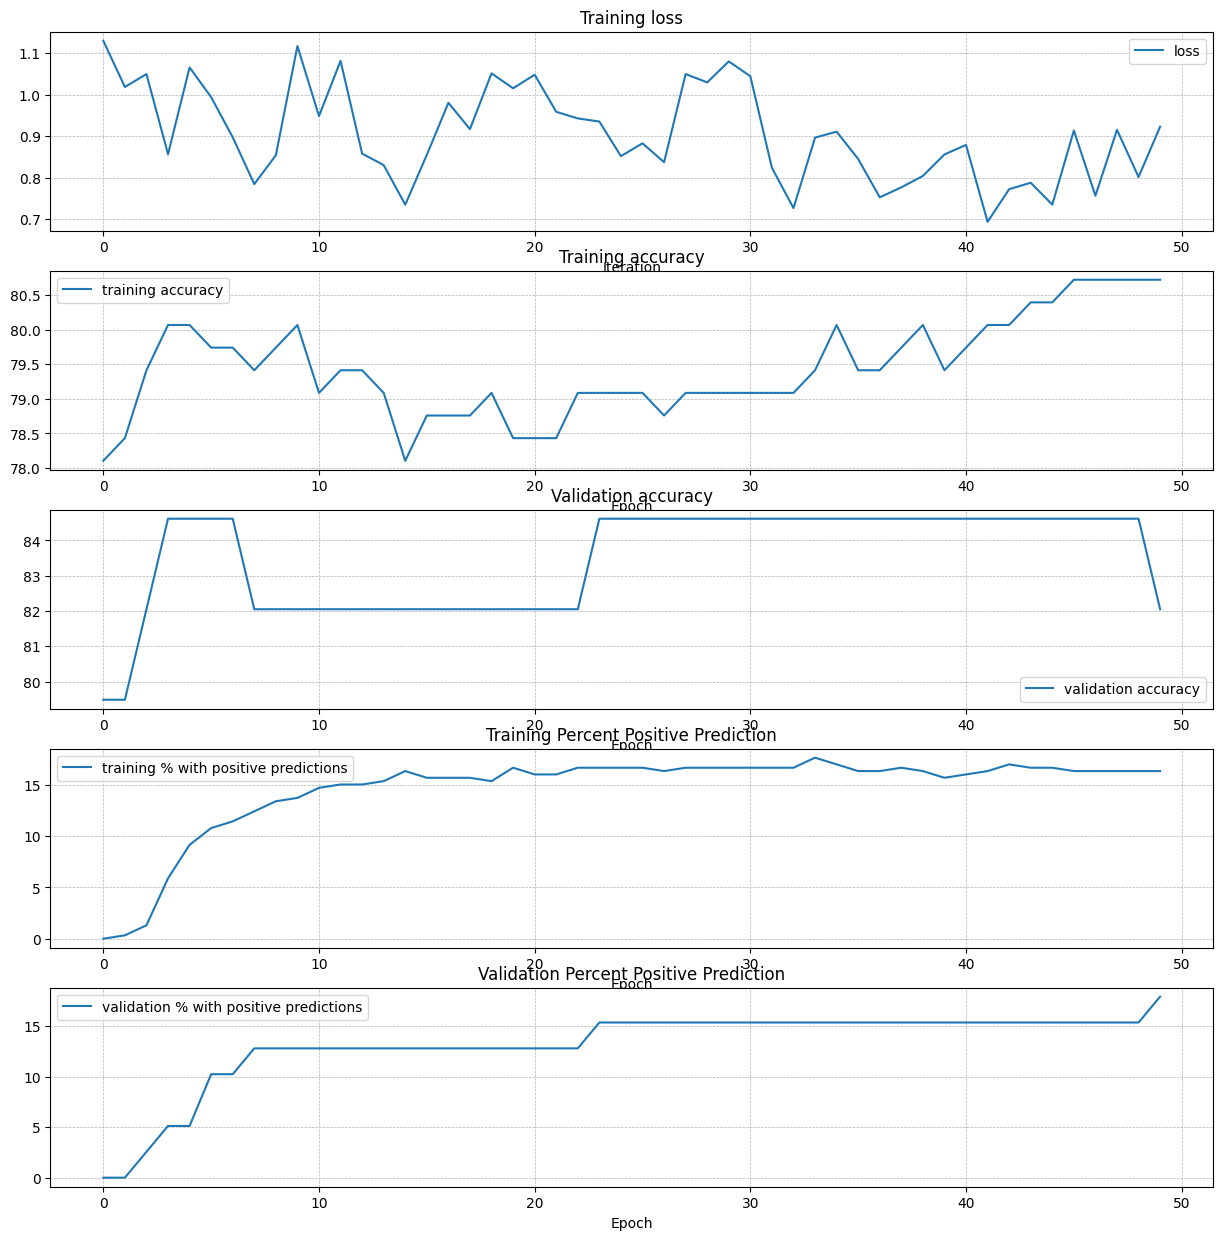

Finished running for lr: 1e-06, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.0310, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.9016, train_acc = 78.7582, val_acc = 82.0513, train_pos = 15.0327, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 0.7411, train_acc = 78.7582, val_acc = 82.0513, train_pos = 18.3007, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.4615384615384615
Epoch 30, loss = 0.8291, train_acc = 78.4314, val_acc = 84.6154, train_pos = 17.3203, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.7284, train_acc = 80.0654, val_acc = 84.6154, train_pos = 16.9935, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715
Epoch 50, loss = 0.8494, train_acc = 80.7190, val_acc = 82.0513, train_pos = 16.9935, val_pos = 17.9487
Epoch 50, Average Validation F1 Score: 0.53

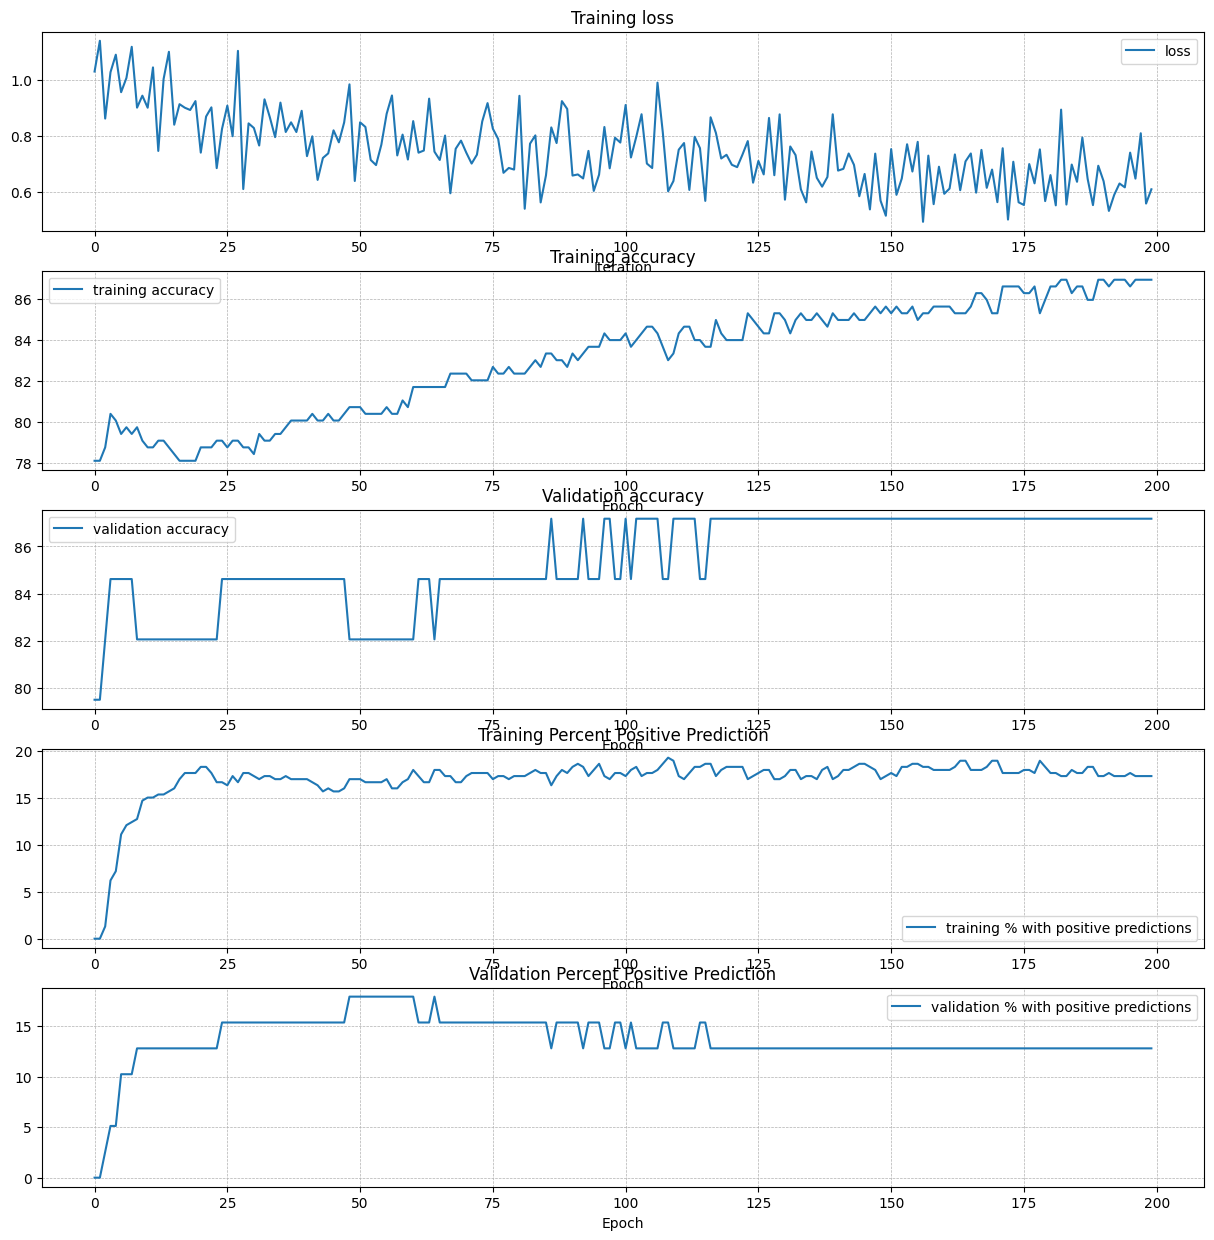

Finished running for lr: 1e-06, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.0921, train_acc = 78.1046, val_acc = 79.4872, train_pos = 0.0000, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 1.0420, train_acc = 79.7386, val_acc = 82.0513, train_pos = 13.3987, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 0.8925, train_acc = 78.7582, val_acc = 82.0513, train_pos = 16.3399, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.4615384615384615
Epoch 30, loss = 1.0054, train_acc = 79.0850, val_acc = 84.6154, train_pos = 16.6667, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.7848, train_acc = 80.0654, val_acc = 84.6154, train_pos = 16.3399, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715
Epoch 50, loss = 0.7485, train_acc = 80.0654, val_acc = 84.6154, train_pos = 15.6863, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.5

Epoch 500, loss = 0.3749, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 500, Average Validation F1 Score: 0.5714285714285715
Epoch 510, loss = 0.3816, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 510, Average Validation F1 Score: 0.5714285714285715
Epoch 520, loss = 0.4108, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 520, Average Validation F1 Score: 0.5714285714285715
Epoch 530, loss = 0.4409, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 530, Average Validation F1 Score: 0.5714285714285715
Epoch 540, loss = 0.4837, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 540, Average Validation F1 Score: 0.5714285714285715
Epoch 550, loss = 0.3238, train_acc = 93.4641, val_acc = 84.6154, train_pos = 19.2810, val_pos = 15.3846
Epoch 550, Average Validation F1 Score: 0.5714285714285715
Epoch 560, loss 

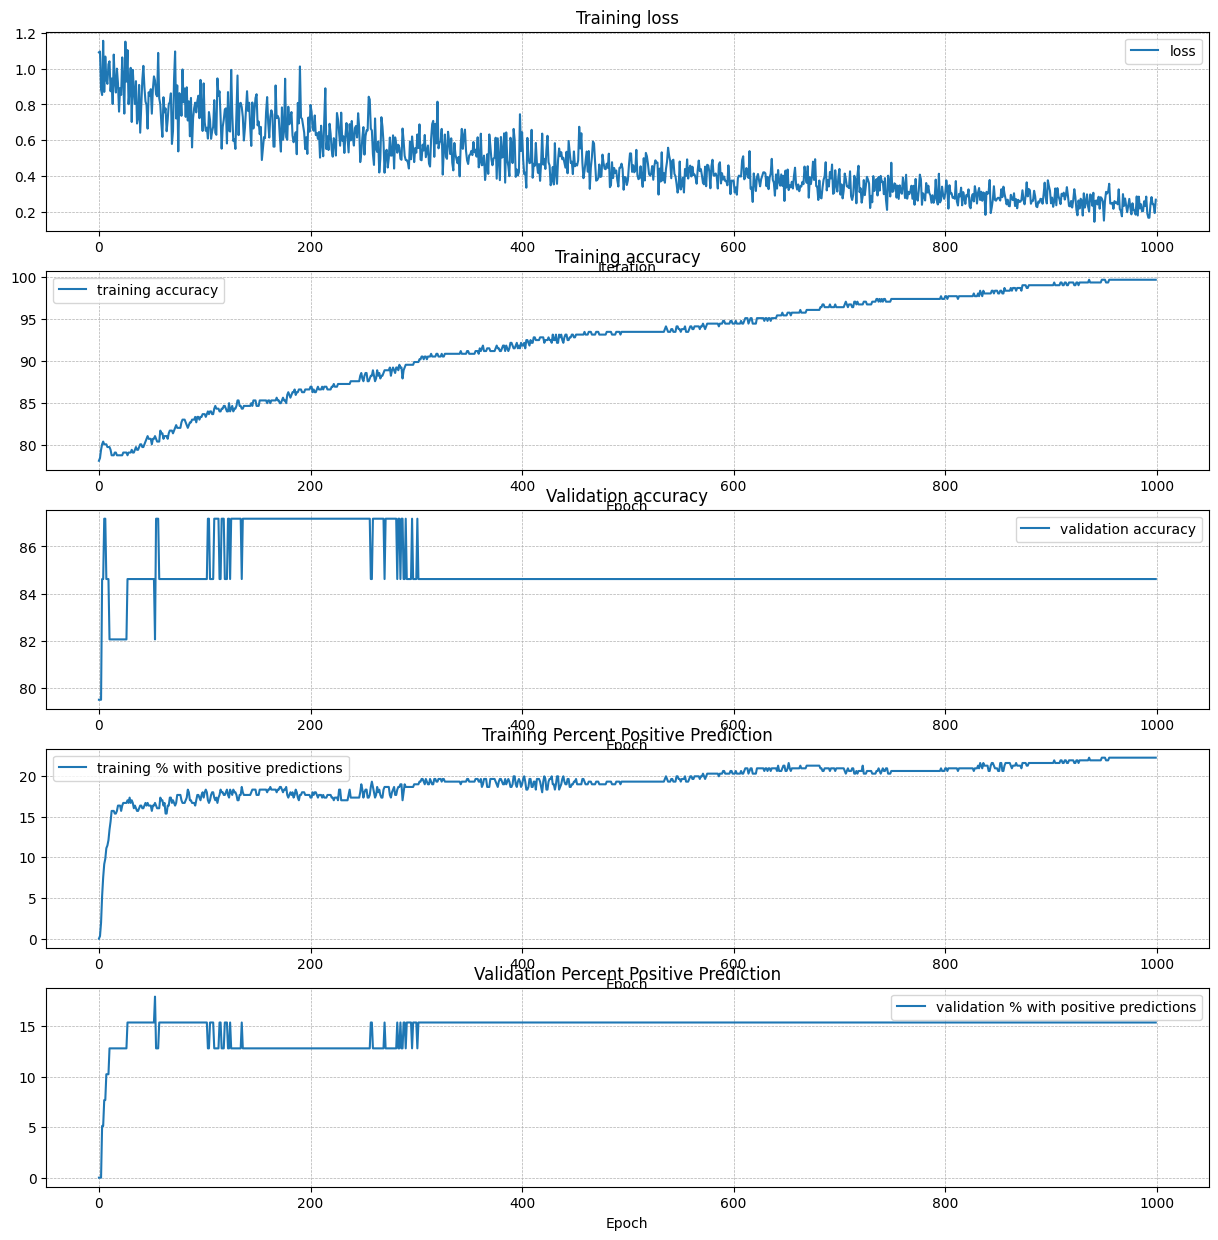

Finished running for lr: 1e-06, hidden size: 1000, epochs: 1000
Epoch 0, loss = 1.0964, train_acc = 78.7582, val_acc = 84.6154, train_pos = 3.2680, val_pos = 20.5128
Epoch 0, Average Validation F1 Score: 0.625
Epoch 10, loss = 1.2338, train_acc = 82.0261, val_acc = 84.6154, train_pos = 15.6863, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.6569, train_acc = 85.9477, val_acc = 82.0513, train_pos = 18.9542, val_pos = 17.9487
Epoch 20, Average Validation F1 Score: 0.5333333333333333
Epoch 30, loss = 0.6805, train_acc = 87.9085, val_acc = 84.6154, train_pos = 17.6471, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.6591, train_acc = 90.1961, val_acc = 87.1795, train_pos = 16.0131, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.6153846153846154


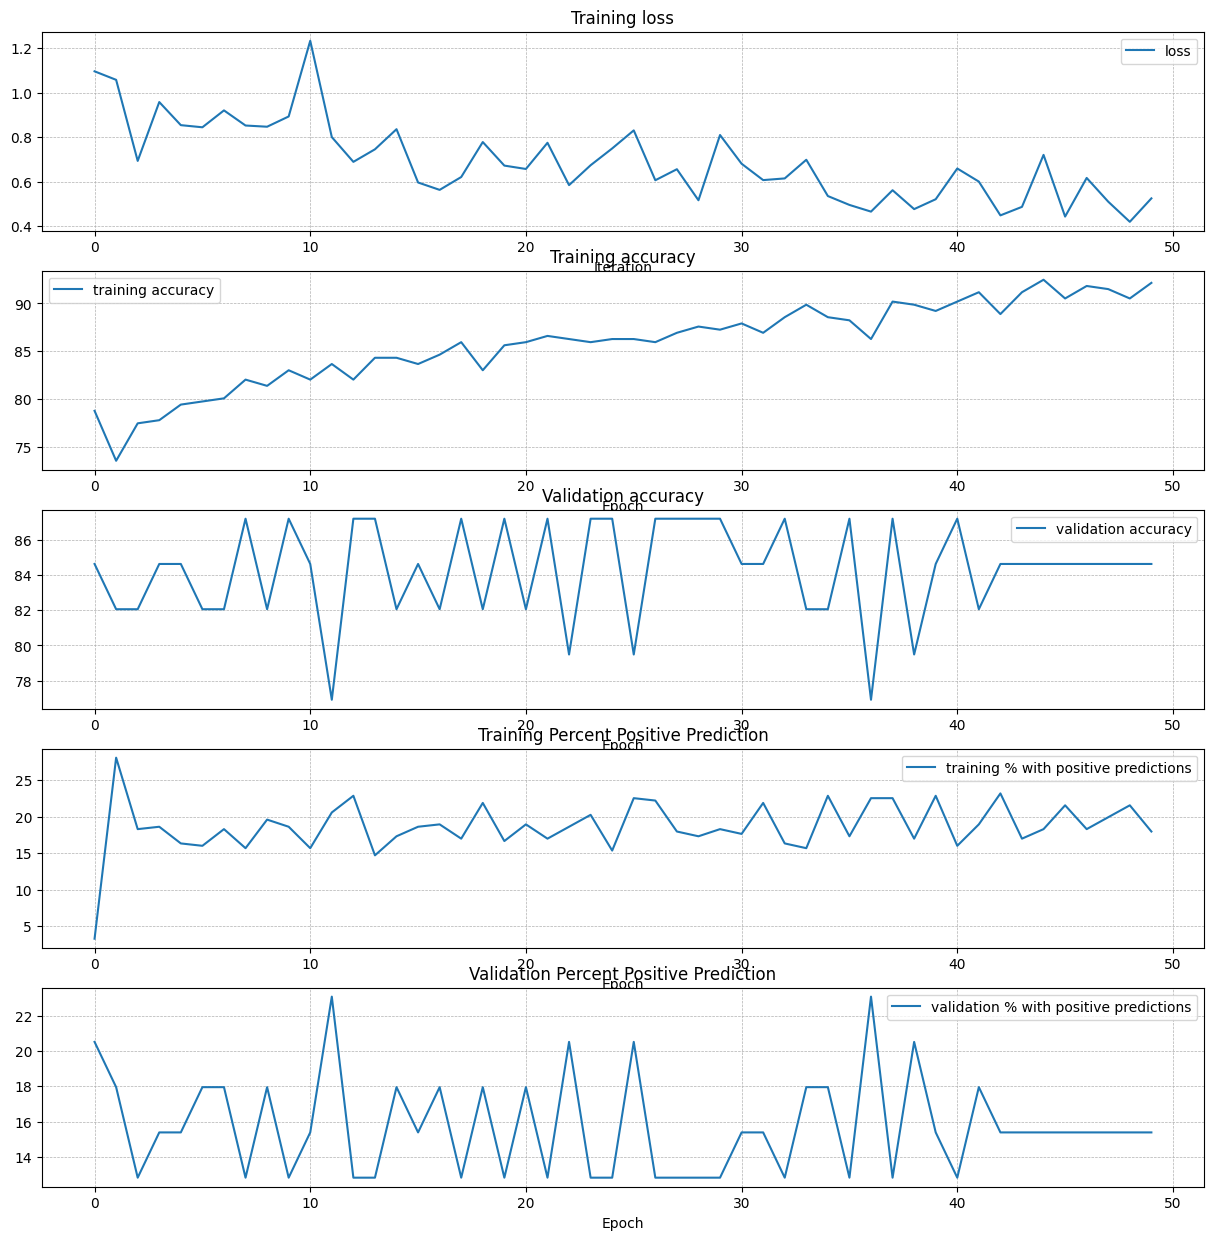

Finished running for lr: 1e-05, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.1640, train_acc = 75.4902, val_acc = 84.6154, train_pos = 7.1895, val_pos = 10.2564
Epoch 0, Average Validation F1 Score: 0.5
Epoch 10, loss = 1.2237, train_acc = 83.9869, val_acc = 87.1795, train_pos = 13.7255, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.6153846153846154
Epoch 20, loss = 0.5522, train_acc = 85.2941, val_acc = 84.6154, train_pos = 16.9935, val_pos = 15.3846
Epoch 20, Average Validation F1 Score: 0.5714285714285715
Epoch 30, loss = 0.5894, train_acc = 87.2549, val_acc = 76.9231, train_pos = 20.2614, val_pos = 23.0769
Epoch 30, Average Validation F1 Score: 0.47058823529411764
Epoch 40, loss = 0.4720, train_acc = 89.8693, val_acc = 84.6154, train_pos = 20.2614, val_pos = 15.3846
Epoch 40, Average Validation F1 Score: 0.5714285714285715
Epoch 50, loss = 0.6407, train_acc = 91.8301, val_acc = 84.6154, train_pos = 18.3007, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.

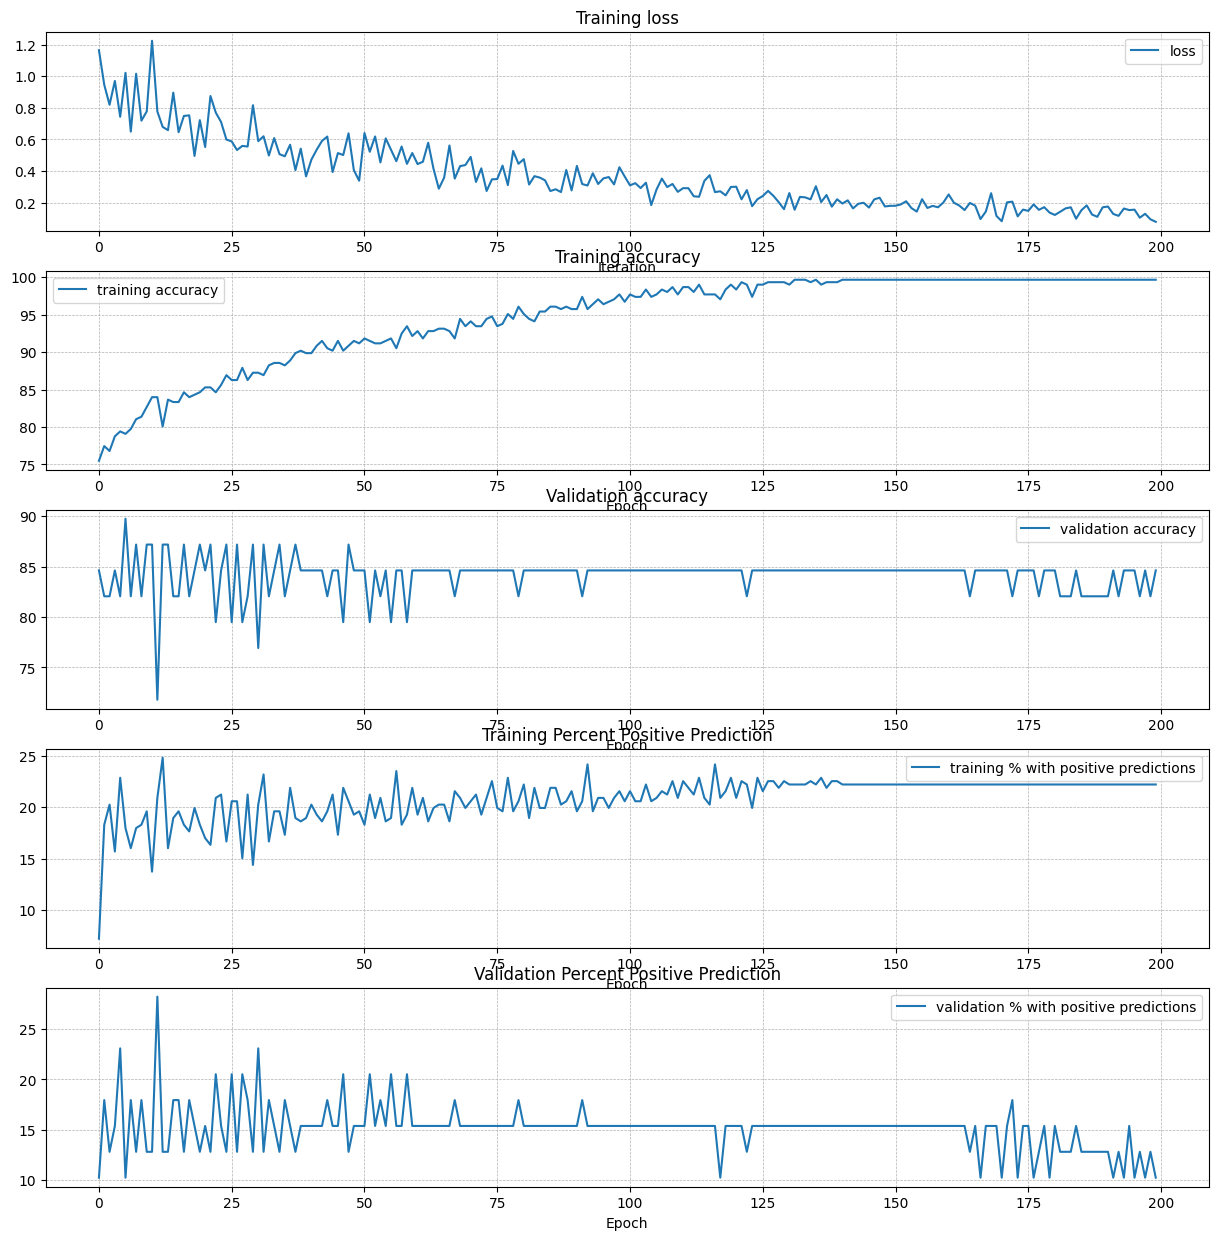

Finished running for lr: 1e-05, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.0216, train_acc = 75.4902, val_acc = 82.0513, train_pos = 14.3791, val_pos = 7.6923
Epoch 0, Average Validation F1 Score: 0.36363636363636365
Epoch 10, loss = 0.9046, train_acc = 82.3529, val_acc = 74.3590, train_pos = 14.7059, val_pos = 25.6410
Epoch 10, Average Validation F1 Score: 0.4444444444444445
Epoch 20, loss = 0.9719, train_acc = 85.2941, val_acc = 79.4872, train_pos = 18.9542, val_pos = 20.5128
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.4502, train_acc = 87.9085, val_acc = 87.1795, train_pos = 19.6078, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.6153846153846154
Epoch 40, loss = 0.6927, train_acc = 89.2157, val_acc = 82.0513, train_pos = 20.9150, val_pos = 17.9487
Epoch 40, Average Validation F1 Score: 0.5333333333333333
Epoch 50, loss = 0.5168, train_acc = 91.5033, val_acc = 79.4872, train_pos = 18.6275, val_pos = 20.5128
Epoch 50, Average Validation F1 Score: 0

Epoch 510, loss = 0.0172, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 510, Average Validation F1 Score: 0.42857142857142855
Epoch 520, loss = 0.0151, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 520, Average Validation F1 Score: 0.42857142857142855
Epoch 530, loss = 0.0139, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 530, Average Validation F1 Score: 0.4615384615384615
Epoch 540, loss = 0.0073, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 540, Average Validation F1 Score: 0.4615384615384615
Epoch 550, loss = 0.0111, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 550, Average Validation F1 Score: 0.42857142857142855
Epoch 560, loss = 0.0093, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 560, Average Validation F1 Score: 0.42857142857142855
Epoch 

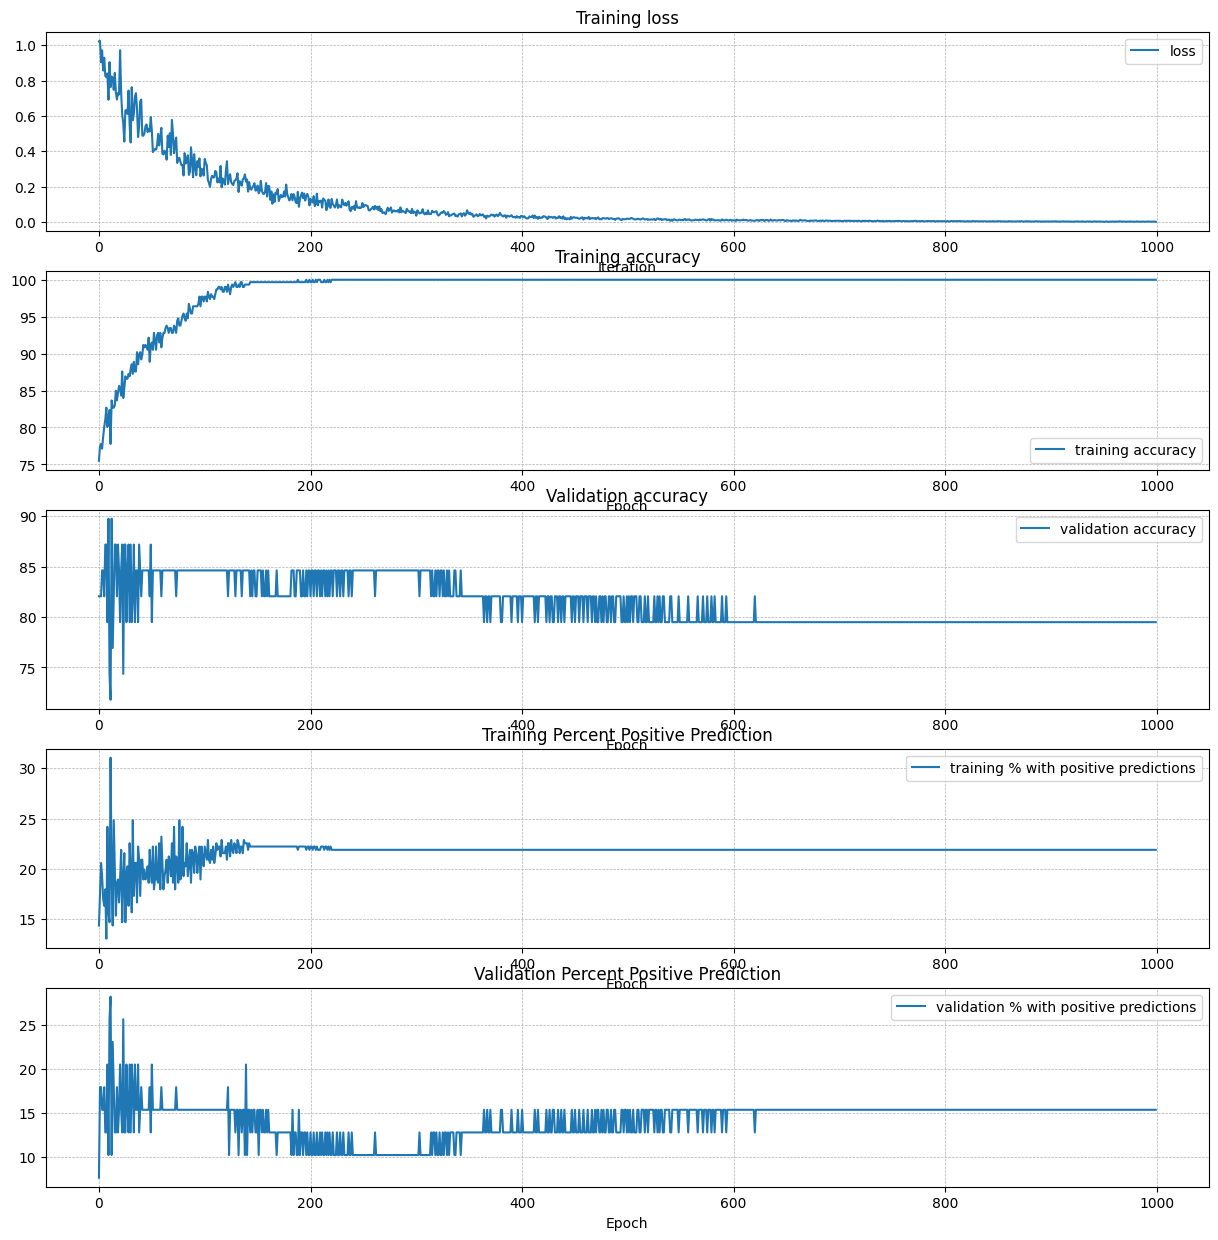

Finished running for lr: 1e-05, hidden size: 1000, epochs: 1000
Epoch 0, loss = 1.2341, train_acc = 64.7059, val_acc = 79.4872, train_pos = 27.7778, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.7843, train_acc = 83.3333, val_acc = 89.7436, train_pos = 15.0327, val_pos = 10.2564
Epoch 10, Average Validation F1 Score: 0.6666666666666666
Epoch 20, loss = 0.7524, train_acc = 89.2157, val_acc = 82.0513, train_pos = 16.3399, val_pos = 17.9487
Epoch 20, Average Validation F1 Score: 0.5333333333333333
Epoch 30, loss = 0.5590, train_acc = 89.5425, val_acc = 74.3590, train_pos = 21.2418, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.4444444444444445
Epoch 40, loss = 0.3586, train_acc = 95.0980, val_acc = 82.0513, train_pos = 20.2614, val_pos = 12.8205
Epoch 40, Average Validation F1 Score: 0.4615384615384615


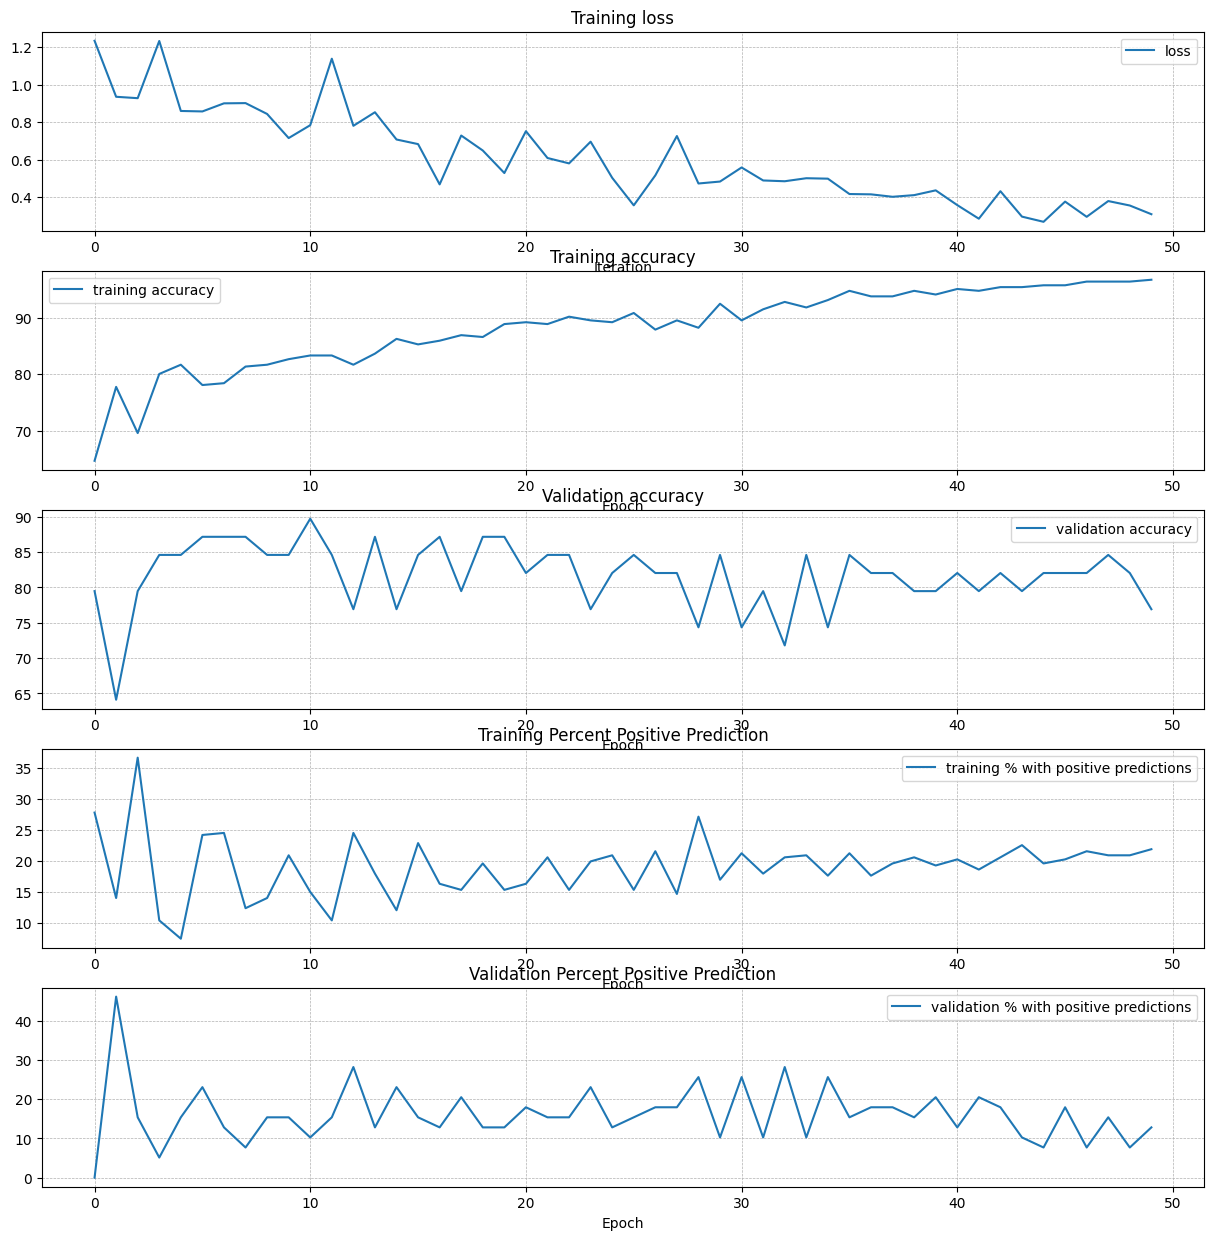

Finished running for lr: 0.0001, hidden size: 1000, epochs: 50
Epoch 0, loss = 1.2758, train_acc = 71.2418, val_acc = 84.6154, train_pos = 24.5098, val_pos = 25.6410
Epoch 0, Average Validation F1 Score: 0.6666666666666665
Epoch 10, loss = 0.7681, train_acc = 87.2549, val_acc = 76.9231, train_pos = 15.0327, val_pos = 28.2051
Epoch 10, Average Validation F1 Score: 0.5263157894736842
Epoch 20, loss = 0.4389, train_acc = 92.1569, val_acc = 79.4872, train_pos = 21.8954, val_pos = 20.5128
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.2490, train_acc = 96.7320, val_acc = 84.6154, train_pos = 21.2418, val_pos = 20.5128
Epoch 30, Average Validation F1 Score: 0.625
Epoch 40, loss = 0.2801, train_acc = 96.7320, val_acc = 84.6154, train_pos = 21.8954, val_pos = 20.5128
Epoch 40, Average Validation F1 Score: 0.625
Epoch 50, loss = 0.1019, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 50, Average Validation F1 Score: 0.4615384615384615
Epoch 6

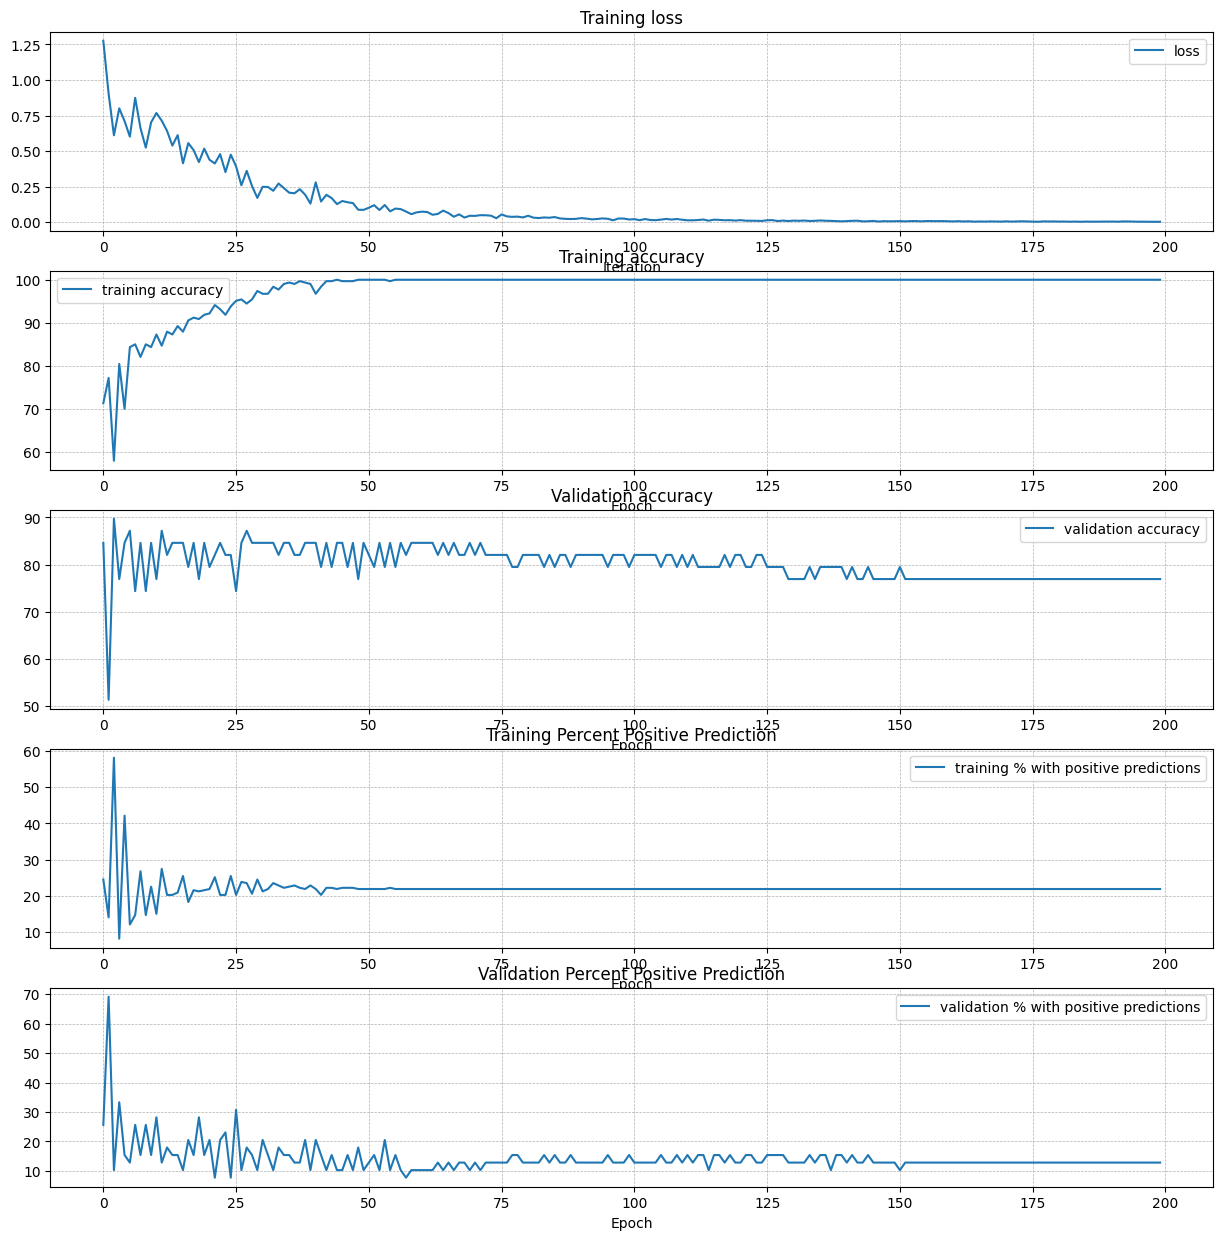

Finished running for lr: 0.0001, hidden size: 1000, epochs: 200
Epoch 0, loss = 1.2521, train_acc = 65.3595, val_acc = 79.4872, train_pos = 30.3922, val_pos = 0.0000
Epoch 0, Average Validation F1 Score: 0.0
Epoch 10, loss = 0.7583, train_acc = 84.9673, val_acc = 82.0513, train_pos = 9.4771, val_pos = 17.9487
Epoch 10, Average Validation F1 Score: 0.5333333333333333
Epoch 20, loss = 0.5507, train_acc = 89.8693, val_acc = 84.6154, train_pos = 19.6078, val_pos = 15.3846
Epoch 20, Average Validation F1 Score: 0.5714285714285715
Epoch 30, loss = 0.3954, train_acc = 94.4444, val_acc = 82.0513, train_pos = 20.2614, val_pos = 17.9487
Epoch 30, Average Validation F1 Score: 0.5333333333333333
Epoch 40, loss = 0.2591, train_acc = 96.4052, val_acc = 82.0513, train_pos = 22.8758, val_pos = 7.6923
Epoch 40, Average Validation F1 Score: 0.36363636363636365
Epoch 50, loss = 0.2309, train_acc = 98.3660, val_acc = 84.6154, train_pos = 23.5294, val_pos = 10.2564
Epoch 50, Average Validation F1 Score: 0.

Epoch 500, loss = 0.0011, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 500, Average Validation F1 Score: 0.4615384615384615
Epoch 510, loss = 0.0007, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 510, Average Validation F1 Score: 0.4615384615384615
Epoch 520, loss = 0.0010, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 520, Average Validation F1 Score: 0.4615384615384615
Epoch 530, loss = 0.0007, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 530, Average Validation F1 Score: 0.4615384615384615
Epoch 540, loss = 0.0007, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 540, Average Validation F1 Score: 0.4615384615384615
Epoch 550, loss = 0.0005, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 550, Average Validation F1 Score: 0.4615384615384615
Epoch 560,

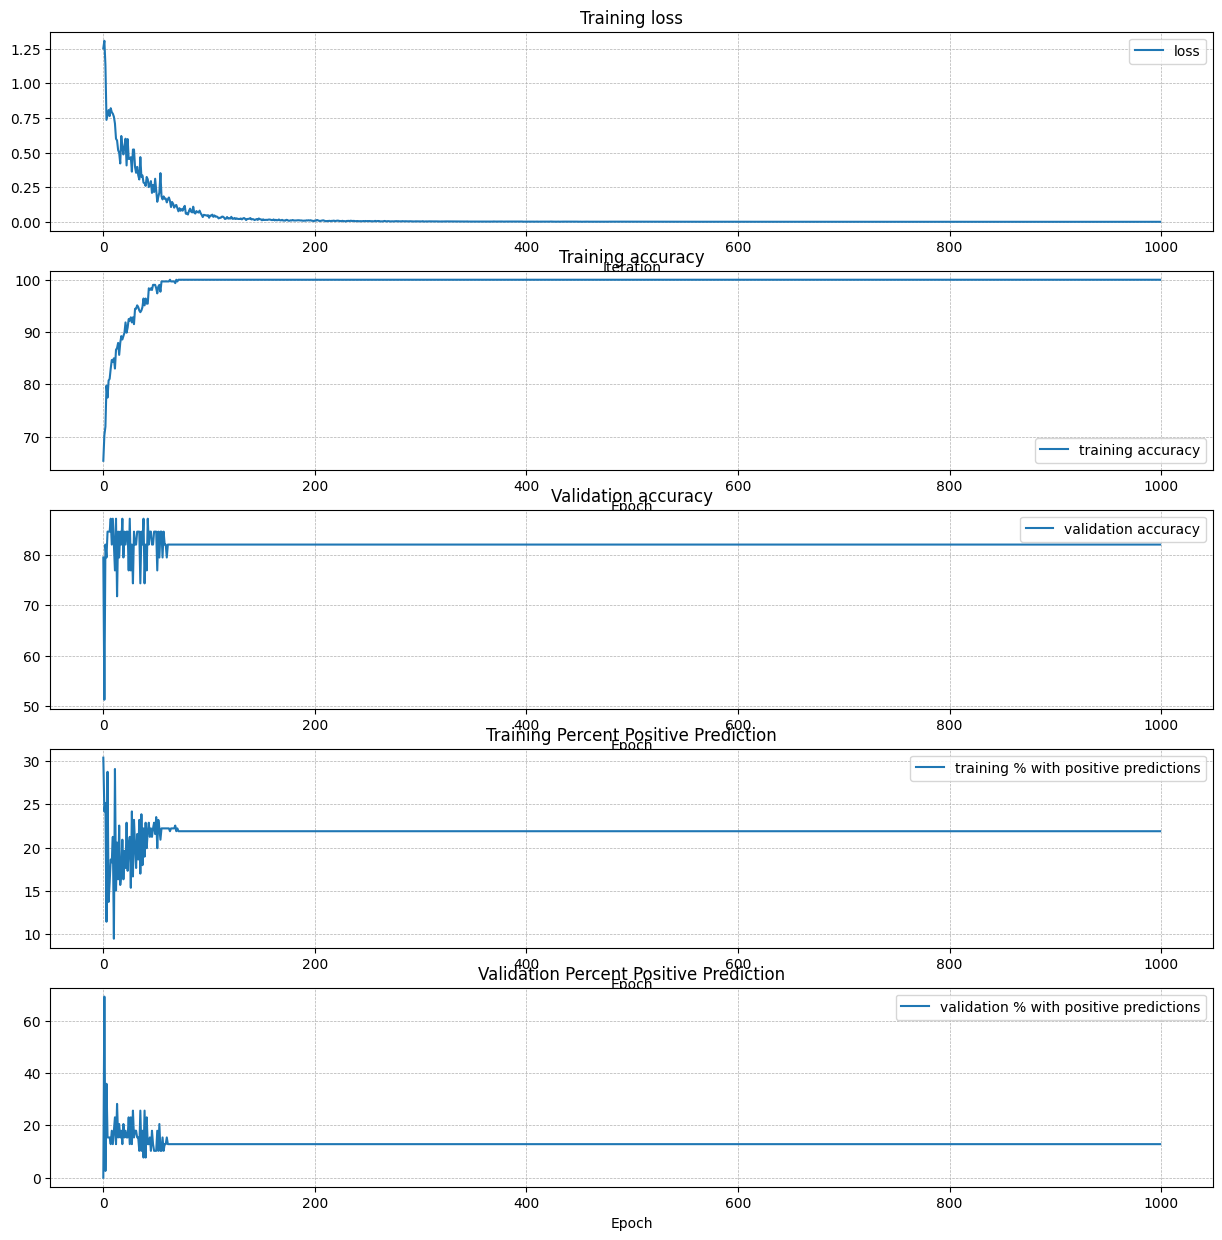

Finished running for lr: 0.0001, hidden size: 1000, epochs: 1000
Epoch 0, loss = 5.2249, train_acc = 64.3791, val_acc = 23.0769, train_pos = 30.0654, val_pos = 97.4359
Epoch 0, Average Validation F1 Score: 0.34782608695652173
Epoch 10, loss = 0.5327, train_acc = 88.5621, val_acc = 84.6154, train_pos = 24.8366, val_pos = 15.3846
Epoch 10, Average Validation F1 Score: 0.5714285714285715
Epoch 20, loss = 0.2331, train_acc = 97.0588, val_acc = 79.4872, train_pos = 24.1830, val_pos = 25.6410
Epoch 20, Average Validation F1 Score: 0.5555555555555556
Epoch 30, loss = 0.1337, train_acc = 99.0196, val_acc = 74.3590, train_pos = 20.9150, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.4444444444444445
Epoch 40, loss = 0.0666, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 7.6923
Epoch 40, Average Validation F1 Score: 0.36363636363636365


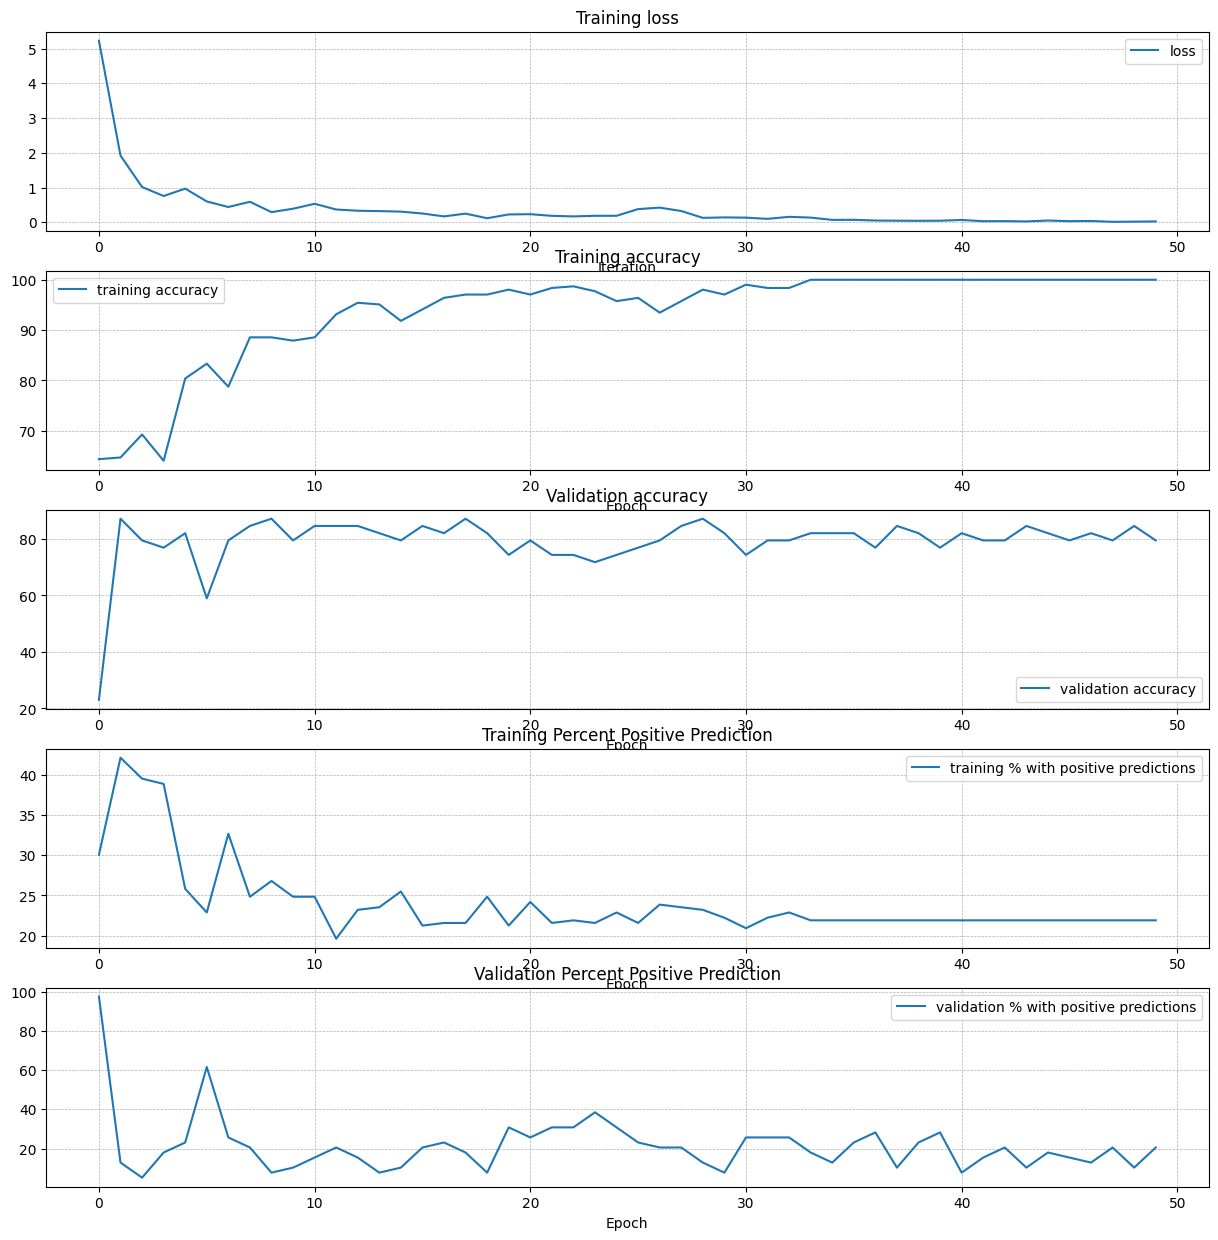

Finished running for lr: 0.001, hidden size: 1000, epochs: 50
Epoch 0, loss = 6.1836, train_acc = 63.0719, val_acc = 20.5128, train_pos = 27.4510, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 0.5075, train_acc = 82.6797, val_acc = 82.0513, train_pos = 32.0261, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 0.3782, train_acc = 91.1765, val_acc = 71.7949, train_pos = 18.3007, val_pos = 28.2051
Epoch 20, Average Validation F1 Score: 0.4210526315789474
Epoch 30, loss = 0.1746, train_acc = 97.0588, val_acc = 87.1795, train_pos = 23.5294, val_pos = 12.8205
Epoch 30, Average Validation F1 Score: 0.6153846153846154
Epoch 40, loss = 0.1579, train_acc = 99.3464, val_acc = 87.1795, train_pos = 21.8954, val_pos = 17.9487
Epoch 40, Average Validation F1 Score: 0.6666666666666666
Epoch 50, loss = 0.0728, train_acc = 99.0196, val_acc = 84.6154, train_pos = 22.8758, val_pos = 10.2564
Epoch 50, Average Validat

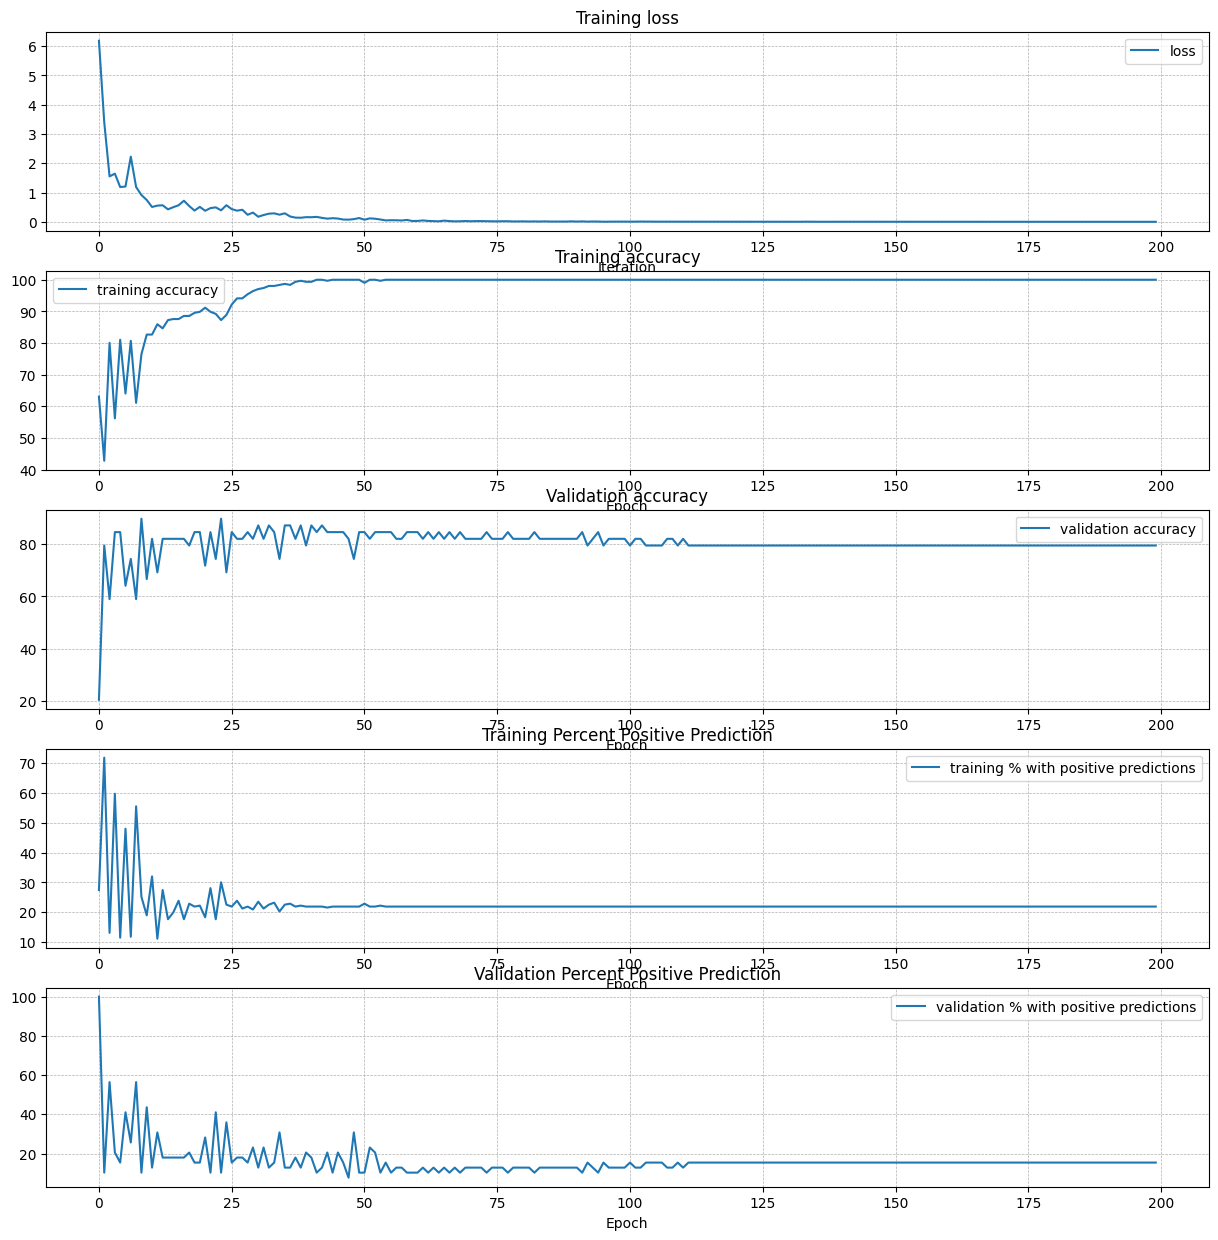

Finished running for lr: 0.001, hidden size: 1000, epochs: 200
Epoch 0, loss = 4.0167, train_acc = 63.0719, val_acc = 53.8462, train_pos = 35.2941, val_pos = 66.6667
Epoch 0, Average Validation F1 Score: 0.47058823529411764
Epoch 10, loss = 0.4069, train_acc = 84.6405, val_acc = 82.0513, train_pos = 32.6797, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 0.3000, train_acc = 95.0980, val_acc = 87.1795, train_pos = 25.4902, val_pos = 7.6923
Epoch 20, Average Validation F1 Score: 0.5454545454545454
Epoch 30, loss = 0.1737, train_acc = 99.6732, val_acc = 84.6154, train_pos = 22.2222, val_pos = 20.5128
Epoch 30, Average Validation F1 Score: 0.625
Epoch 40, loss = 0.0598, train_acc = 100.0000, val_acc = 71.7949, train_pos = 21.8954, val_pos = 33.3333
Epoch 40, Average Validation F1 Score: 0.4761904761904762
Epoch 50, loss = 0.0479, train_acc = 100.0000, val_acc = 82.0513, train_pos = 21.8954, val_pos = 12.8205
Epoch 50, Average Validation F1 Scor

Epoch 500, loss = 0.0002, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 500, Average Validation F1 Score: 0.39999999999999997
Epoch 510, loss = 0.0002, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 510, Average Validation F1 Score: 0.39999999999999997
Epoch 520, loss = 0.0002, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 520, Average Validation F1 Score: 0.39999999999999997
Epoch 530, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 530, Average Validation F1 Score: 0.39999999999999997
Epoch 540, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 540, Average Validation F1 Score: 0.39999999999999997
Epoch 550, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 550, Average Validation F1 Score: 0.39999999999999997
Epoc

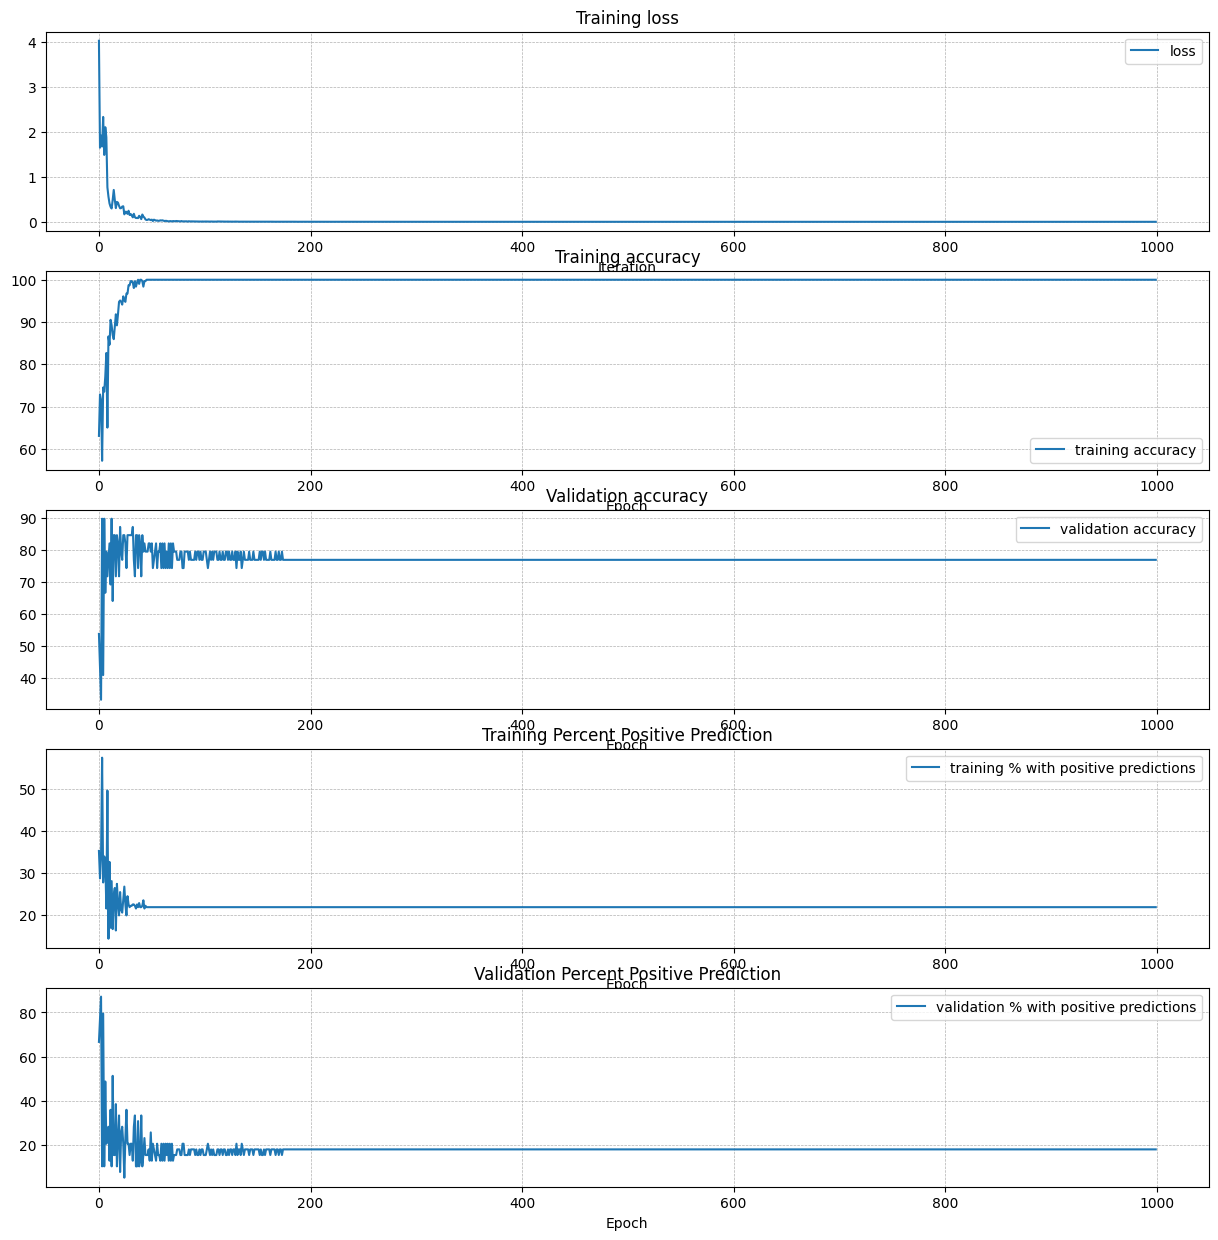

Finished running for lr: 0.001, hidden size: 1000, epochs: 1000
Epoch 0, loss = 36.1037, train_acc = 62.0915, val_acc = 20.5128, train_pos = 27.7778, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 0.8561, train_acc = 80.3922, val_acc = 82.0513, train_pos = 12.0915, val_pos = 12.8205
Epoch 10, Average Validation F1 Score: 0.4615384615384615
Epoch 20, loss = 0.8218, train_acc = 84.6405, val_acc = 74.3590, train_pos = 20.9150, val_pos = 20.5128
Epoch 20, Average Validation F1 Score: 0.375
Epoch 30, loss = 0.6059, train_acc = 91.5033, val_acc = 84.6154, train_pos = 25.1634, val_pos = 15.3846
Epoch 30, Average Validation F1 Score: 0.5714285714285715
Epoch 40, loss = 0.1153, train_acc = 99.0196, val_acc = 82.0513, train_pos = 21.5686, val_pos = 7.6923
Epoch 40, Average Validation F1 Score: 0.36363636363636365


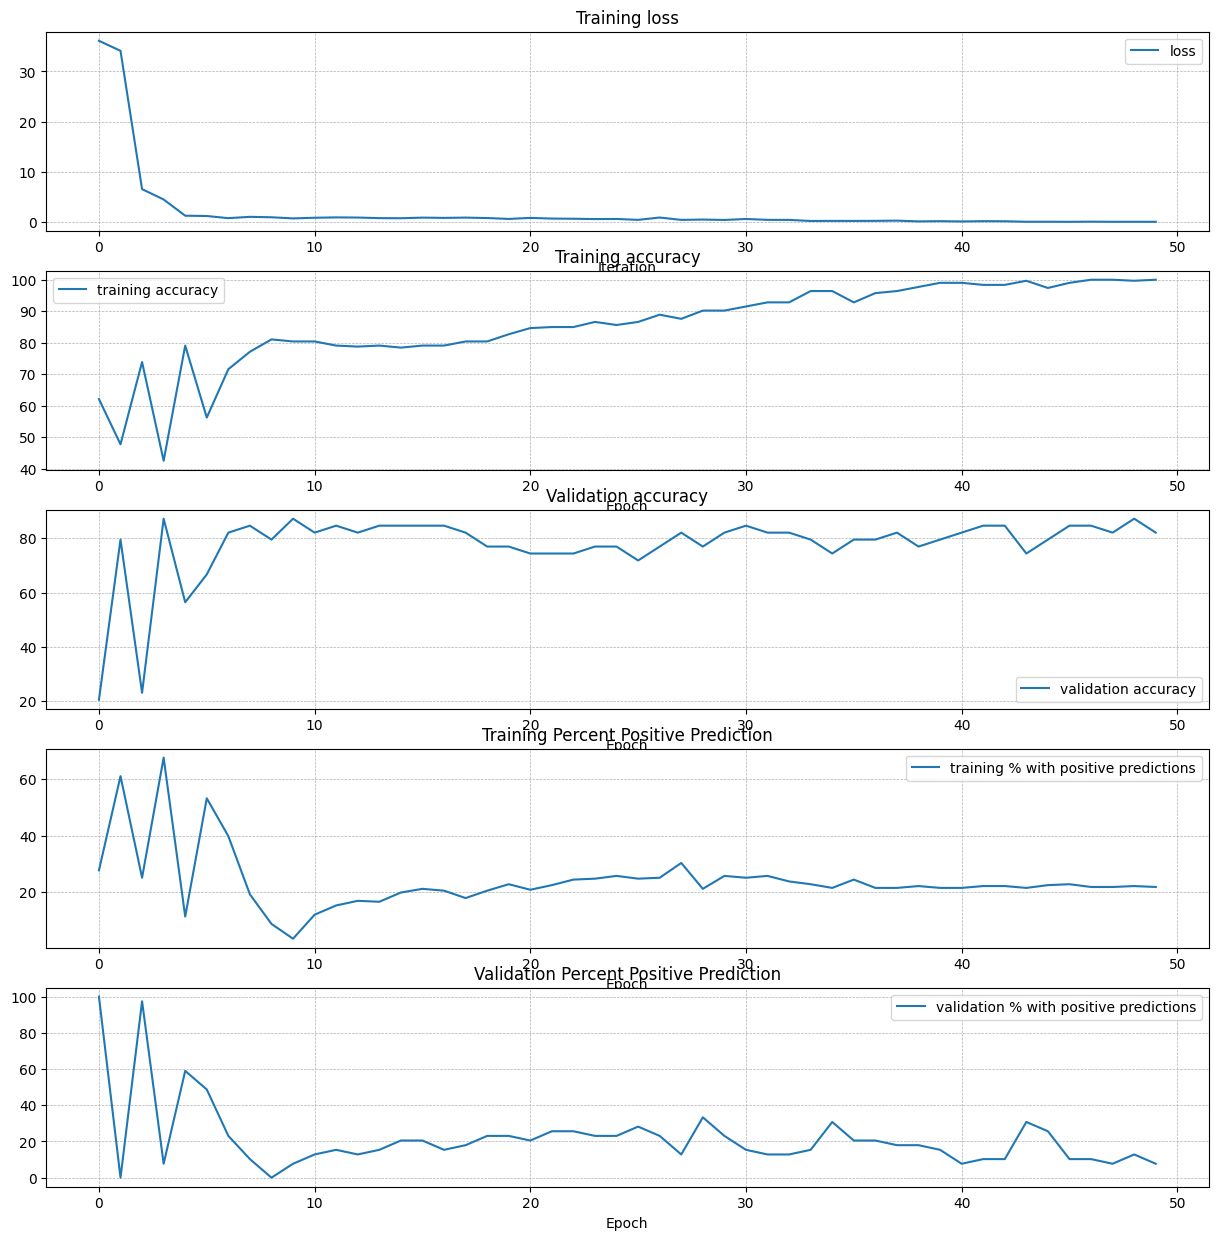

Finished running for lr: 0.01, hidden size: 1000, epochs: 50
Epoch 0, loss = 69.4339, train_acc = 67.9739, val_acc = 25.6410, train_pos = 22.5490, val_pos = 94.8718
Epoch 0, Average Validation F1 Score: 0.35555555555555557
Epoch 10, loss = 0.7504, train_acc = 79.4118, val_acc = 82.0513, train_pos = 3.9216, val_pos = 2.5641
Epoch 10, Average Validation F1 Score: 0.2222222222222222
Epoch 20, loss = 0.5877, train_acc = 82.0261, val_acc = 82.0513, train_pos = 15.6863, val_pos = 12.8205
Epoch 20, Average Validation F1 Score: 0.4615384615384615
Epoch 30, loss = 0.6566, train_acc = 88.2353, val_acc = 76.9231, train_pos = 23.8562, val_pos = 17.9487
Epoch 30, Average Validation F1 Score: 0.39999999999999997
Epoch 40, loss = 0.2667, train_acc = 92.8105, val_acc = 69.2308, train_pos = 21.2418, val_pos = 30.7692
Epoch 40, Average Validation F1 Score: 0.4
Epoch 50, loss = 0.1073, train_acc = 98.0392, val_acc = 74.3590, train_pos = 19.9346, val_pos = 30.7692
Epoch 50, Average Validation F1 Score: 0.

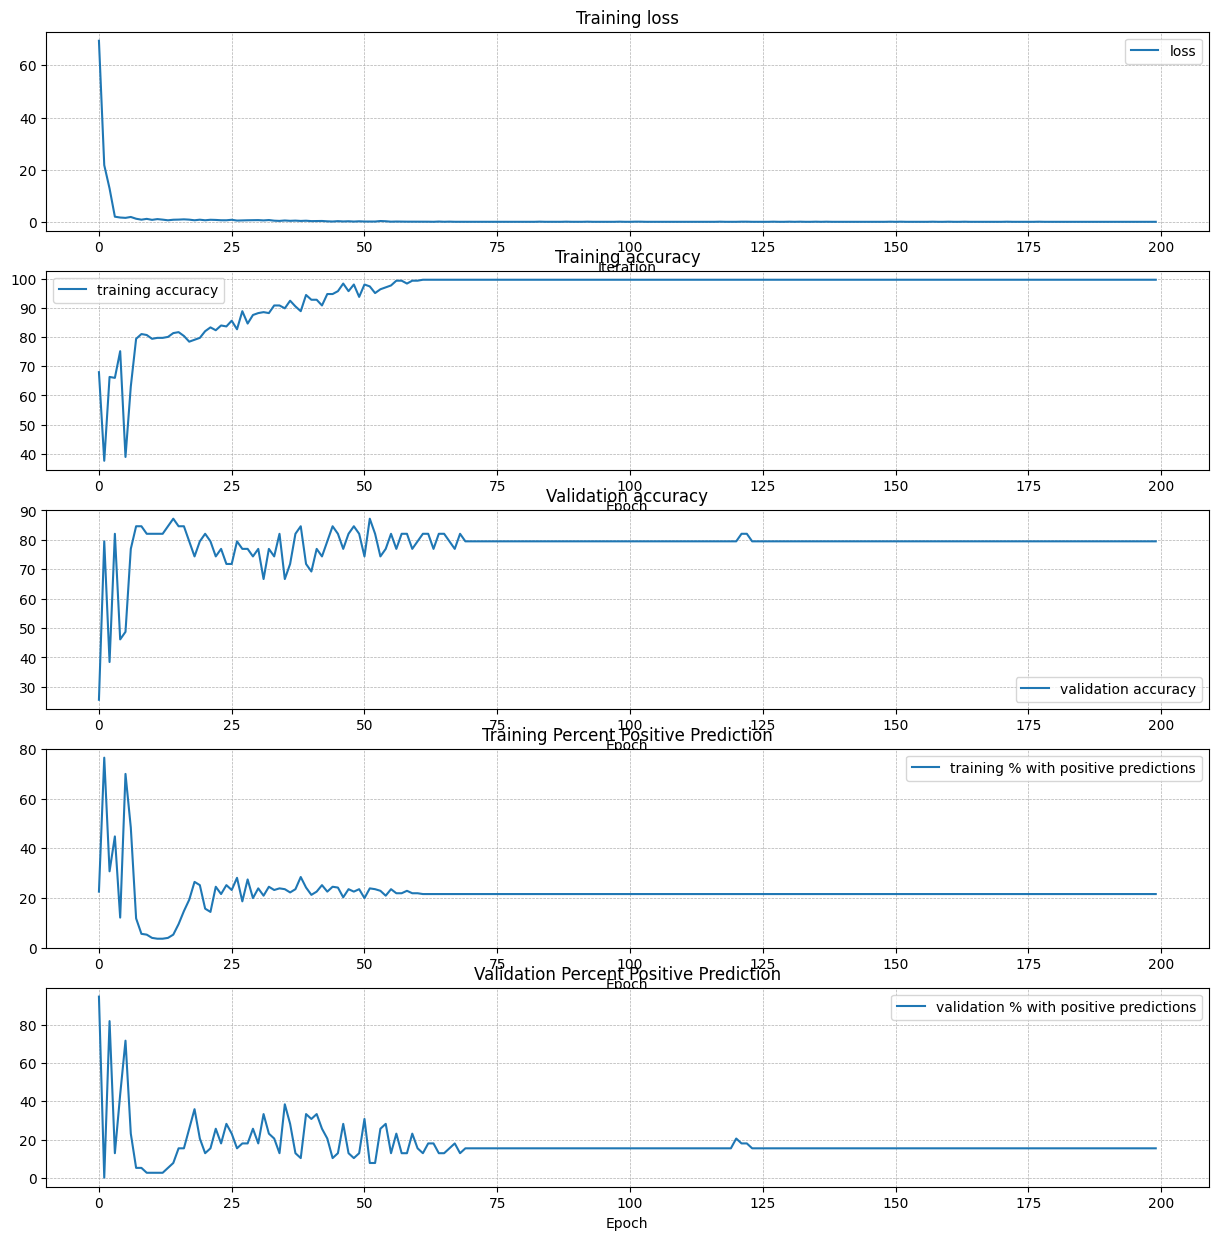

Finished running for lr: 0.01, hidden size: 1000, epochs: 200
Epoch 0, loss = 64.2290, train_acc = 64.3791, val_acc = 20.5128, train_pos = 24.8366, val_pos = 100.0000
Epoch 0, Average Validation F1 Score: 0.3404255319148936
Epoch 10, loss = 0.8381, train_acc = 84.6405, val_acc = 74.3590, train_pos = 14.3791, val_pos = 25.6410
Epoch 10, Average Validation F1 Score: 0.4444444444444445
Epoch 20, loss = 0.4538, train_acc = 91.1765, val_acc = 79.4872, train_pos = 22.2222, val_pos = 20.5128
Epoch 20, Average Validation F1 Score: 0.5
Epoch 30, loss = 0.0849, train_acc = 97.0588, val_acc = 74.3590, train_pos = 23.5294, val_pos = 25.6410
Epoch 30, Average Validation F1 Score: 0.4444444444444445
Epoch 40, loss = 0.1161, train_acc = 99.6732, val_acc = 74.3590, train_pos = 21.5686, val_pos = 30.7692
Epoch 40, Average Validation F1 Score: 0.5
Epoch 50, loss = 0.0289, train_acc = 100.0000, val_acc = 79.4872, train_pos = 21.8954, val_pos = 15.3846
Epoch 50, Average Validation F1 Score: 0.428571428571

Epoch 500, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 500, Average Validation F1 Score: 0.39999999999999997
Epoch 510, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 510, Average Validation F1 Score: 0.39999999999999997
Epoch 520, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 520, Average Validation F1 Score: 0.39999999999999997
Epoch 530, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 530, Average Validation F1 Score: 0.39999999999999997
Epoch 540, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 540, Average Validation F1 Score: 0.39999999999999997
Epoch 550, loss = 0.0001, train_acc = 100.0000, val_acc = 76.9231, train_pos = 21.8954, val_pos = 17.9487
Epoch 550, Average Validation F1 Score: 0.39999999999999997
Epoc

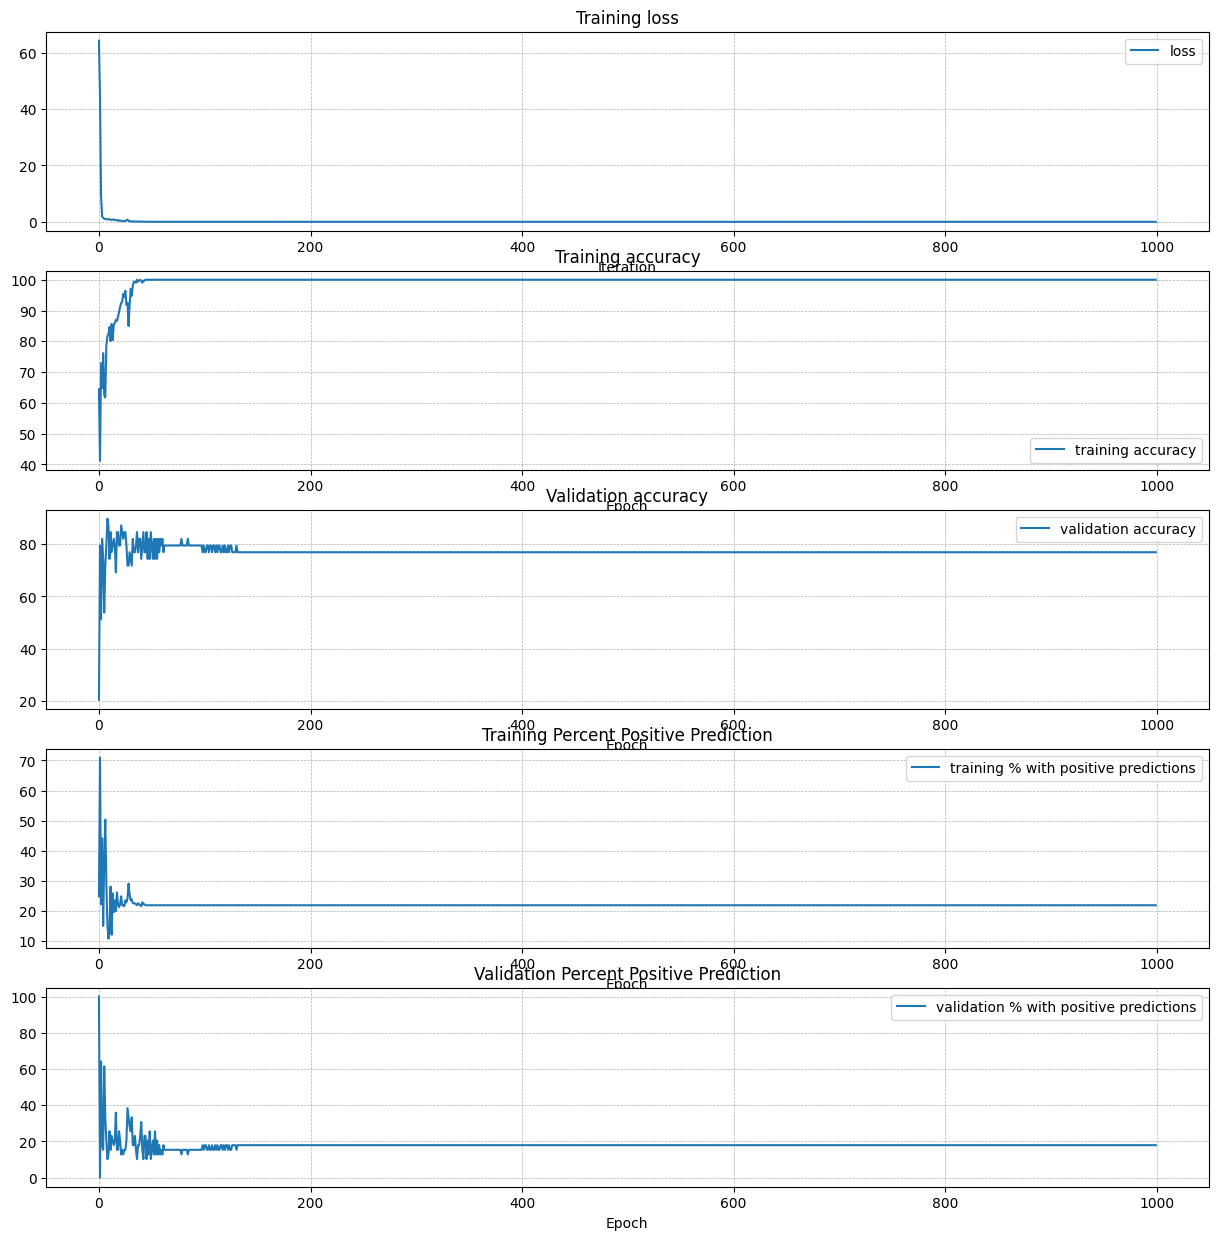

Finished running for lr: 0.01, hidden size: 1000, epochs: 1000


RuntimeError: CUDA out of memory. Tried to allocate 588.00 MiB (GPU 0; 14.75 GiB total capacity; 2.89 GiB already allocated; 372.81 MiB free; 2.89 GiB reserved in total by PyTorch)

In [14]:
# use weighted loss instead of oversampling 
train = CustomDataset(dataframe=train_data, transform=None)
loader_train = DataLoader(train, batch_size=64, 
                       sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

val = CustomDataset(dataframe=val_data, transform=None)
loader_val = DataLoader(val, batch_size=64, 
                        sampler=sampler.SubsetRandomSampler(range(NUM_VAL)))

test = CustomDataset(dataframe=test_data, transform=None)
loader_test = DataLoader(test, batch_size=64)

input_size = 77061
hidden_sizes = [100, 1000, 2000, 5000, 10000]
lrs = [0.000001, 0.00001, 0.0001, 0.001, 0.01]
epochs = [50, 200, 1000]
num_samples_pos = train_data[train_data['OA_check']==1].shape[0]
num_samples_neg = train_data[train_data['OA_check']==0].shape[0]
num_classes = 1

best_model = None
best_val = 0
accuracies = {}

for hidden_size in hidden_sizes:
    for lr in lrs: 
        for num_epochs in epochs:
            model = Barebones_model(input_size, hidden_size, num_classes)
            optimizer = optim.Adam(model.parameters(), lr=lr)
            loss, train_acc, val_acc, train_pos, val_pos = train_model(model, optimizer, loader_train, loader_val, epochs=num_epochs, \
                use_BCE_weight=True, num_samples_pos=num_samples_pos, num_samples_neg=num_samples_neg, verbose=False)

            fig, axes = plt.subplots(5, 1, figsize=(15, 15))

            axes[0].set_title('Training loss')
            axes[0].set_xlabel('Iteration')
            axes[1].set_title('Training accuracy')
            axes[1].set_xlabel('Epoch')
            axes[2].set_title('Validation accuracy')
            axes[2].set_xlabel('Epoch')
            axes[3].set_title('Training Percent Positive Prediction')
            axes[3].set_xlabel('Epoch')
            axes[4].set_title('Validation Percent Positive Prediction')
            axes[4].set_xlabel('Epoch')

            axes[0].plot(loss, label="loss")
            axes[1].plot(train_acc, label="training accuracy")
            axes[2].plot(val_acc, label="validation accuracy")
            axes[3].plot(train_pos, label="training % with positive predictions")
            axes[4].plot(val_pos, label="validation % with positive predictions")

            for ax in axes:
                ax.legend(loc='best', ncol=4)
                ax.grid(linestyle='--', linewidth=0.5)

            plt.show()

            if best_val < val_acc[-1]:
                best_val = val_acc[-1]
                best_model = model
            
            accuracies["lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs)] = val_acc[-1]
            print("Finished running for lr: {}, hidden size: {}, epochs: {}".format(lr, hidden_size, num_epochs))

In [ ]:
best_model

In [ ]:
print(check_accuracy(loader_val, best_model))
print(check_accuracy(loader_test, best_model))

In [ ]:
# best: 'lr: 1e-06, hidden size: 2000, epochs: 50'
accuracies

In [ ]:
plot_roc_curve(best_model, loader_val, device)